In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
mk=2
gdp_true = True
import numpy as np
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/2022_Fall/Research_Burger/DataFinalDiscrete.csv')
data

,Action,Own,Rival,Pop,Inc,Val,GDP,INF,MarketType,agent,year
0,1,0,0,2,2,3,1,1,1.0,aw,1970
1,1,0,0,2,2,3,0,1,1.0,aw,1970
2,1,0,0,2,2,3,1,1,1.0,aw,1970
3,1,0,0,2,2,3,1,1,1.0,aw,1970
4,1,0,0,2,2,3,0,0,1.0,aw,1971
...,...,...,...,...,...,...,...,...,...,...,...
279995,1,0,0,1,3,2,1,1,1.0,wdy,2003
279996,1,0,0,1,3,2,1,0,1.0,wdy,2004
279997,1,0,0,1,3,2,1,1,1.0,wdy,2004
279998,1,0,0,1,3,2,1,1,1.0,wdy,2004


In [3]:
numstates = 5 # ni,nj,pop,val,inc
states_full = np.arange(4**numstates)
Ni = states_full//(4**(numstates-1))                       #Number of own outlets: {0,1,2,3+}.
Nj = states_full%(4**(numstates-1))//(4**(numstates-2))    #Number of rival outlets: {0,1,2,3+}.
dz1 = states_full%(4**(numstates-2))//(4**(numstates-3))   #Discretized population state: {0,1,2,3}.
dz2 = states_full%(4**(numstates-3))//(4**(numstates-4))   #Discretized property value state: {0,1,2,3}.
dz3 = states_full%(4**(numstates-4))                       #Discretized income state: {0,1,2,3}.
print(np.sum(np.abs(Ni*4**4+Nj*4**3+dz1*4**2+dz2*4**1+dz3-states_full)))
states = np.stack([Ni,Nj,dz1,dz2,dz3],axis=1)
TimeLength = 140
MT = len(data)

0


##Partial

###1. Global transtion F_Ni, F_dz1,F_dz2,F_dz3

In [4]:
obser = 2
I = 2 #MCD and Other homogenous
J = 3 #Action: 0,1,2
NS = 4**(numstates)
NX = 15
NZ = obser

F_Ni = np.zeros([I,J,NX,NS,NS])#;
#for i in range(NX): 
F_Ni[0,0] = np.kron(np.array([[1]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) +\
                          [[1]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[1]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [1] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) ),np.ones([NX,1,1]))
F_Ni[0,1] =np.kron(np.array([[1]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) +\
                          [[0]*4**(numstates-1)+[1]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [1] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[1]*4**(numstates-1)]*4**(numstates-1) ),np.ones([NX,1,1]))
F_Ni[0,2] = np.kron(np.array([[0]*4**(numstates-1)+[1]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) +\
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [1] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[1]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[1]*4**(numstates-1)]*4**(numstates-1) ),np.ones([NX,1,1]))
F_Ni[1] = F_Ni[0]

disc_pop_mx = data['Pop'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy().reshape([-1,TimeLength])
disc_val_mx = data['Val'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy().reshape([-1,TimeLength])
disc_inc_mx = data['Inc'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy().reshape([-1,TimeLength])


#% F_dz: Make simple & intuitive (4x4) versions for exposition purposes
fz1_4x4 = np.zeros([4,4])#;
fz2_4x4 = np.zeros([4,4])#;
fz3_4x4 = np.zeros([4,4])#;
for x0 in range(4):
    for x1 in range(4):
        numer1 =  np.sum((disc_pop_mx[:,1:] == x1) * (disc_pop_mx[:,0:-1] == x0))#;
        denom1 =  np.sum((disc_pop_mx[:,0:-1] == x0))#;
        numer2 =  np.sum((disc_val_mx[:,1:] == x1) * (disc_val_mx[:,0:-1] == x0))#;
        denom2 =  np.sum((disc_val_mx[:,0:-1] == x0))#;
        numer3 =  np.sum((disc_inc_mx[:,1:] == x1) * (disc_inc_mx[:,0:-1] == x0))#;
        denom3 =  np.sum((disc_inc_mx[:,0:-1] == x0))#;
        fz1_4x4[x0,x1] = numer1 / denom1#;
        fz2_4x4[x0,x1] = numer2 / denom2#;
        fz3_4x4[x0,x1] = numer3 / denom3#;

for i in range(4):
  print("&{}&{:.4f}&{:.4f}&{:.4f}&{:.4f}\\\\".format(i,fz1_4x4[i][0],fz1_4x4[i][1],fz1_4x4[i][2],fz1_4x4[i][3]))
print('------------------------------')
for i in range(4):
  print("&{}&{:.4f}&{:.4f}&{:.4f}&{:.4f}\\\\".format(i,fz2_4x4[i][0],fz2_4x4[i][1],fz2_4x4[i][2],fz2_4x4[i][3]))
print('------------------------------')
for i in range(4):
  print("&{}&{:.4f}&{:.4f}&{:.4f}&{:.4f}\\\\".format(i,fz3_4x4[i][0],fz3_4x4[i][1],fz3_4x4[i][2],fz3_4x4[i][3]))
print('------------------------------')
print(fz1_4x4)
print(fz2_4x4)
print(fz3_4x4)

F_dz1 = np.kron((fz1_4x4[dz1,:])[:,dz1],np.ones([I,J,NX,1,1]))#; % The transition pattern is common across (i,j,mtype)
F_dz2 = np.kron((fz2_4x4[dz2,:])[:,dz2],np.ones([I,J,NX,1,1]))#; % The transition pattern is common across (i,j,mtype)
F_dz3 = np.kron((fz3_4x4[dz3,:])[:,dz3],np.ones([I,J,NX,1,1]))#; % The transition pattern is common across (i,j,mtype)

&0&0.9949&0.0051&0.0000&0.0000\\
&1&0.0000&0.9883&0.0117&0.0000\\
&2&0.0000&0.0000&0.9898&0.0102\\
&3&0.0000&0.0000&0.0003&0.9997\\
------------------------------
&0&0.9828&0.0172&0.0000&0.0000\\
&1&0.0002&0.9787&0.0211&0.0000\\
&2&0.0000&0.0016&0.9733&0.0251\\
&3&0.0000&0.0000&0.0033&0.9967\\
------------------------------
&0&0.9773&0.0227&0.0000&0.0000\\
&1&0.0020&0.9662&0.0318&0.0000\\
&2&0.0000&0.0042&0.9759&0.0199\\
&3&0.0000&0.0000&0.0042&0.9958\\
------------------------------
[[9.94888995e-01 5.11100463e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.88251880e-01 1.17481203e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.89832007e-01 1.01679929e-02]
 [0.00000000e+00 0.00000000e+00 2.78940028e-04 9.99721060e-01]]
[[9.82754759e-01 1.72452408e-02 0.00000000e+00 0.00000000e+00]
 [2.06526229e-04 9.78727798e-01 2.10656753e-02 0.00000000e+00]
 [0.00000000e+00 1.55520995e-03 9.73339258e-01 2.51055321e-02]
 [0.00000000e+00 0.00000000e+00 3.32088003e-03 9.96679120e-01]]
[[0.9

###2. Dynamix and SigmaLambda

In [5]:
import itertools
dim_hstate = 2
dim_observe = obser
def Dynamic(theta23):
  trans_val = theta23[0:2]
  obser_val = theta23[2:]

  trans = np.zeros([dim_hstate,dim_hstate]) #s_t^h,s_{t+1}^h
  trans[:,0] = trans_val
  trans[:,1] = 1-trans[:,0]
  obser = np.zeros([dim_hstate,dim_observe])
  obser[:,0] = [obser_val,1-obser_val]
  #obser[:,0] = obser_val
  obser[:,1] = 1-obser[:,0]
  return trans,obser
#print(Dynamic(np.array([0.95, 0.05]+ [0.125, 0.125])))#,0.125]+[0.1])))#,0.1,0.1])))  

def SigmaLambda(theta23,z_old = None,x_old=None,T=None,num_discrete = NX):
  trans,obser = Dynamic(theta23)
  if T==None: #generate function for Q function
    x_old =  np.linspace(0,1,num=num_discrete)
    x_new = np.zeros([num_discrete,dim_observe]) #x_old,z_old,z_new
    sigma = np.zeros([num_discrete,dim_observe])

    for z in range(dim_observe):
      #for z_prime in range(dim_observe):
        x_temp = (x_old*trans[0,0] + (1-x_old) * trans[1,0])*obser[0,z]#,z_prime]
        sigma[:,z] = x_temp + (x_old*trans[0,1] + (1-x_old) * trans[1,1])*obser[1,z]#,z_prime]
        sigma_nonzero = np.where(sigma[:,z]!=0)
        x_new[:,z][sigma_nonzero] = x_temp[sigma_nonzero]/sigma[:,z][sigma_nonzero]
  elif T==1:
    x_temp = (x_old*trans[0,0]+(1-x_old)*trans[1,0])*obser[0,z_old]
    sigma = x_temp + (x_old*trans[0,1]+(1-x_old)*trans[1,1])*obser[1,z_old]
    #sigma_nonzero = np.where(sigma!=0)
    x_new = x_temp/sigma#[sigma_nonzero]/sigma[sigma_nonzero]
  else: #generate whole blief in recover process
    x_new = np.zeros([T,len(x_old)])
    sigma = np.zeros([T-1,len(x_old)])
    x_new[0] = x_old
    for t in range(T-1):
      #z = z_old[t,:]
      z_prime = z_old[t+1,:]
      x_temp = (x_new[t]*trans[0,0]+(1-x_new[t])*trans[1,0])*obser[0,z_prime]
      sigma[t] = x_temp + (x_new[t]*trans[0,1]+(1-x_new[t])*trans[1,1])*obser[1,z_prime]
      sigma_nonzero = np.where(sigma[t]!=0)
      x_new[t+1][sigma_nonzero] = x_temp[sigma_nonzero]/sigma[t][sigma_nonzero]

  belief_f = np.floor(x_new*(num_discrete-1))/(num_discrete-1)
  belief_c = np.ceil(x_new*(num_discrete-1))/(num_discrete-1)
  iterpolate = np.zeros(belief_f.shape)
  iterpolate[np.where((belief_f-belief_c)!=0)] = (x_new-belief_c)[np.where((belief_f-belief_c)!=0)]/(belief_f-belief_c)[np.where((belief_f-belief_c)!=0)]      

  return sigma,x_new,[iterpolate,np.int_(belief_f*(num_discrete-1)),np.int_(belief_c*(num_discrete-1))]

# theta23 = np.array([0.95, 0.05,0.125, 0.125])#,0.125]+[0.1])#,0.1,0.1])
# sigma,_,(iterp,iterf,iterc) = SigmaLambda(theta23)

### 3. Generate P(nj|policy)

In [6]:
F_fix = F_Ni * F_dz1 * F_dz2 *F_dz3
# % Calculate F from P (& global transition matrices F_Ni, F_dz1, F_dz2) 
import time
def updateF(P):
  #% For a given combination of (Ni, dz1, dz2, mtype), make the state indexes (x, x0, x1, x2, x3)
  #% Beliefs: mapping from today's state (Ni,Nj,dz1,dz2) to tomorrow's Nj = {0,1,2,3}
  fnj_mcd = np.zeros([NX,NS,4])#;      % McDonald's belief
  fnj_other = np.zeros([NX,NS,4])#;    % Other 4 chains beliefs

  nj = 0#;         % If today's # of rivals = 0
  x =  (4**4)*Ni + (4**3)*nj + (4**2)*dz1 + 4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 + 4*dz2+dz3#;  % index of today's state for rivals with 0 shops

  fnj_mcd[:,x,0] = P[1,1][:,x0]**4#;                               % Prob(Nj'= 0) from McD's perspective
  fnj_mcd[:,x,1] = 4 * P[1,2][:,x0] * (P[1,1][:,x0]**3)#;       % Prob(Nj'= 1) from McD's perspective
  fnj_mcd[:,x,2] = 6 * (P[1,2][:,x0]**2) * (P[1,1][:,x0]**2)#;   % Prob(Nj'= 2) from McD's perspective
  fnj_mcd[:,x,3] = 4 * (P[1,2][:,x0]**3) * P[1,1][:,x0]#;       % Prob(Nj'= 3) from McD's perspective
  
  fnj_other[:,x,0] = P[0,1][:,x0] * (P[1,1][:,x0]**3)#;         % Prob(Nj'= 0) etc. from Others' perspectives
  fnj_other[:,x,1] = P[0,2][:,x0] * (P[1,1][:,x0]**3) + P[0,1][:,x0] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)#;  
  fnj_other[:,x,2] = P[0,2][:,x0] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2) + P[0,1][:,x0] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0]
  fnj_other[:,x,3] = P[0,2][:,x0] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0] + P[0,1][:,x0] * (P[1,2][:,x0]**3)
  
  nj = 1#;         % If today's # of rivals = 1                               
  x =  (4**4)*Ni + (4**3)*nj + (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 =  (4**4)*1 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  
  fnj_mcd[:,x,0] = P[1,0][:,x1] * (P[1,1][:,x0]**3)#;
  fnj_mcd[:,x,1] = P[1,1][:,x1] * (P[1,1][:,x0]**3)#;
  fnj_mcd[:,x,2] = P[1,2][:,x1] * (P[1,1][:,x0]**3) + P[1,1][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)#;
  fnj_mcd[:,x,3] = P[1,2][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2) + P[1,1][:,x1] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0]
  
  fnj_other[:,x,0] = .5 * (P[0,0][:,x1] * P[1,1][:,x0]**3) + .5 * (P[0,1][:,x0] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,1] = .5 * (P[0,1][:,x1] * P[1,1][:,x0]**3) + .5 * (P[0,1][:,x0] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .5 * (P[0,2][:,x1] * (P[1,1][:,x0]**3) + P[0,1][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2))+\
                              .5 * (P[0,2][:,x0] * P[1,1][:,x1] * (P[1,1][:,x0]**2) +\
                        P[0,1][:,x0] * (P[1,2][:,x1] * (P[1,1][:,x0]**2) + P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]))
  fnj_other[:,x,3] = .5 * (P[0,2][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)\
                        + P[0,1][:,x1] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0])\
                        + .5 * (P[0,2][:,x0] * P[1,2][:,x1] * (P[1,1][:,x0]**2)\
                      + P[0,2][:,x0] * P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]\
                      + P[0,1][:,x0] * P[1,2][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]\
                      + P[0,1][:,x0] * P[1,1][:,x1] * (P[1,2][:,x0]**2))

  nj = 2#;         % If today's # of rivals = 2
  x = (4**4)*Ni + (4**3)*nj + (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 = (4**4)*1 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x2 = (4**4)*2 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 2 shops
  
  fnj_mcd[:,x,0] = (P[1,0][:,x1]**2) * (P[1,1][:,x0]**2)
  fnj_mcd[:,x,1] = (1/3) * (P[1,0][:,x2] * (P[1,1][:,x0]**3)) + (2/3) * (P[1,0][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,2] = (1/3) * (P[1,1][:,x2] * (P[1,1][:,x0]**3)) + (2/3) * ((P[1,1][:,x1]**2) * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,3] = (1/3) * (P[1,2][:,x2] * (P[1,1][:,x0]**3)  + (P[1,1][:,x2] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)))
  
  fnj_other[:,x,0] = .5 * 0 + .5 * (P[0,0][:,x1] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,1] = .5 * (P[0,0][:,x2] * (P[1,1][:,x0]**3))\
      + .5 * (P[0,0][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .5 * (P[0,1][:,x2] * (P[1,1][:,x0]**3))\
      + .5 * (P[0,1][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,3] = .5 * (P[0,2][:,x2] * (P[1,1][:,x0]**3)\
      + P[0,1][:,x2] * 3 * P[1,2][:,x0] * P[1,1][:,x0])\
      + .5 * (P[0,2][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,2][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0])
  
  nj = 3#;         % If today's # of rivals = 3
  x = (4**4)*Ni + (4**3)*nj + (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 = (4**4)*1 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x2 = (4**4)*2 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 2 shops
  x3 = (4**4)*3 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 3 shops
  
  fnj_mcd[:,x,0] = (2/3) * (P[1,0][:,x1]**3) * P[1,1][:,x0]
  fnj_mcd[:,x,1] = (2/3) * (P[1,0][:,x1]**2) * P[1,1][:,x1] + (1/3) * P[1,0][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2)
  fnj_mcd[:,x,2] = (2/3) * P[1,0][:,x1] * (P[1,1][:,x1]**2) + (1/3) * (P[1,0][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[1,1][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,3] = (2/3) * (P[1,1][:,x1]**3) * P[1,1][:,x0] + (1/3) * P[1,1][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)
  
  fnj_other[:,x,0] = .25 * (P[0,0][:,x1] * (P[1,0][:,x1]**2) * P[1,1][:,x0])
  fnj_other[:,x,1] = .25 * 0 + .25 * (P[0,0][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,0][:,x1] * 2 * P[1,0][:,x1] * P[1,1][:,x1] * P[1,1][:,x0]\
      + P[0,1][:,x1] * (P[1,0][:,x1]**2) * P[1,1][:,x0])\
      + .25 * (P[0,0][:,x1] * P[1,0][:,x2] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .25 * (P[0,0][:,x3] * (P[1,1][:,x0]**3))\
      + .25 * (P[0,0][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,0][:,x1] * (P[1,1][:,x1]**2) * P[1,1][:,x0]\
      + P[0,1][:,x1] * 2 * P[1,0][:,x1] * P[1,1][:,x1] * P[1,1][:,x0])\
      + .25 * (P[0,0][:,x1] * P[1,1][:,x2] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,0][:,x2] * (P[1,1][:,x0]**2))
  fnj_other[:,x,3] = .25 * (P[0,1][:,x3] * (P[1,1][:,x0]**3))\
      + .25 * (P[0,1][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,1][:,x1] * (P[1,1][:,x1]**2) * P[1,1][:,x0])\
      + .25 * (P[0,1][:,x1] * P[1,1][:,x2] * (P[1,1][:,x0]**2))

  F_Nj = np.ones([I,J,NX,NS,NS])
  Denom_mcd = np.matmul(fnj_mcd,np.ones([NX,4,4]))#np.kron(np.reshape(np.sum(fnj_mcd,axis=2),[NX,-1,1]),np.ones([1,1,4]))#;         % Sum of each row
  fnj_mcd = fnj_mcd / Denom_mcd#;                 % Make sure each row sums up to 1
  fnj_mcd[np.isnan(fnj_mcd)] = 0#;                    % Replace NaN with 0
  F_Nj[0,0] = fnj_mcd[:,:,Nj]

  Denom_other = np.matmul(fnj_other,np.ones([NX,4,4]))#np.kron(np.reshape(np.sum(fnj_other,axis=2),[NX,-1,1]),np.ones([1,1,4]))#;             % Sum of each row
  fnj_other = fnj_other / Denom_other#;                   % Make sure each row sums up to 1
  fnj_other[np.isnan(fnj_other)] = 0#;                        % Replace NaN with 0
  F_Nj[1,0] = fnj_other[:,:,Nj]
  #F_Nj[2:5,j,:,:] = np.stack([F_Nj[1,j,:,:] for copy in range(3)],axis=0)#;    % Other 4 chains are symmetric

  for j in range(1,J):    
      F_Nj[:,j] = F_Nj[:,0]    
  return F_Nj*F_fix


# P_new = 1/J*np.ones([I,J,NX,NS])#softmax(np.arange(I*J*NS).reshape([I,J,NS]),axis=1)
# F_new = updateF(P_new.copy())
# #np.sum(F_new!=0)
# print(F_new.shape)

###4.Value Iteration

In [7]:
from scipy.special import logsumexp
from scipy.special import softmax

def updatePi(Q):
  P = np.zeros([I,J,NX,NS])#; player, action, states, Market Type
  P[0] = softmax(Q[0],axis=0)
  P[1] = softmax(Q[1],axis=0)
  P[np.isnan(P)] = 0#;
  return P

def updateQ(thetaS,Q,F,sigmaP,iterpP,iterf,iterc,Q_new,beta = 0.9):

  gamma = 0.5772
    
  v_mcd = np.zeros([J,NX,obser,NS])
  v_other = np.zeros([J,NX,obser,NS])

  v_mcd= iterpP*Q[0][:,iterf,:] + (1-iterpP)*Q[0][:,iterc,:] # Agent, action,NX_new(NX_old,NZ_old,NZ_new), NZ_new,NS_new
  v_other = iterpP*Q[1][:,iterf,:] + (1-iterpP)*Q[1][:,iterc,:]
  #v_mcd = np.stack([iterpP*Q[0,j][iterf]+(1-iterpP)*Q[0,j][iterc] for j in range(J)],axis=0)
  #v_other = np.stack([iterpP*Q[1,j][iterf]+(1-iterpP)*Q[1,j][iterc] for j in range(J)],axis=0)
  v_mcd = gamma + logsumexp(v_mcd,axis=0) #x_old,z_old,z_new,NS_new
  v_other = gamma + logsumexp(v_other,axis=0) #x_old,z_old,z_new,NS_new
  v_mcd = np.sum(sigmaP*v_mcd,axis=1).reshape([1,NX,NS,1]) #x_old,z_old,NS_new
  v_other = np.sum(sigmaP*v_other,axis=1).reshape([1,NX,NS,1])
  v_mcd = np.kron(v_mcd,np.ones([J,1,1,1])) #a_old,x_old,NZ_old,NS_new,1
  v_other = np.kron(v_other,np.ones([J,1,1,1])) #a_old,x_old,NZ_old,NS_new,1

  v_temp_mcd = np.matmul(F[0],v_mcd)[:,:,:,0] # action_old,x_old,nz_old, ns_old (ns_new \times ns_new)
  v_temp_other = np.matmul(F[1],v_other)[:,:,:,0] 

  Q_new[0] = Q_new[0] + beta*(v_temp_mcd) 
  Q_new[1] = Q_new[1] + beta*(v_temp_other)
  return Q_new

#theta23 = np.array([0.95, 0.05]+ [0.9])#, 0.1,0.9,0.1])#,0.1,0.1])
# sigma,_,(iterp,iterf,iterc) = SigmaLambda(theta23)
# sigmaP = np.kron(sigma.reshape([NX,obser,1]),np.ones([1,1,NS]))
# iterpP = np.kron(iterp.reshape([1,NX,obser,1]),np.ones([J,1,1,NS]))


import time

def ValueIteration(thetaS,sigmaP,iterpP,iterf,iterc,error = 5e-3,beta = 0.9):
  Pi0 = 1/3*np.ones([I,J,NX,NS])
  F0= updateF(Pi0)
  Q0 = np.zeros([I,J,NX,NS])
  Pi_old = Pi0
  F_old = F0
  Q_old = Q0

  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([thetaS[2],thetaS[3],thetaS[4],thetaS[5],thetaS[6],thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([thetaS[10],thetaS[11],thetaS[12],thetaS[13],thetaS[14],thetaS[15]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,-1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[8]*    x_old.dot(Ni_temp)+\
                thetaS[9]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  error1 = np.inf
  for iter in range(1000):
    # time_start = time.time()
    Q_new = updateQ(thetaS,Q_old,F_old,sigmaP,iterpP,iterf,iterc,Q_new = R_new.copy(),beta=beta) #I, J, NS
    Pi_new = updatePi(Q_new)#I,J,NS
    #time_start1 = time.time()
    #print(time_start1-time_start)
    F_new = updateF(Pi_new) # I, J, NS,NS
    #print(time.time()-time_start1)
    if iter>0:
      error1 = np.max(np.abs(Q_new-Q_old))/np.max(np.abs(Q_old))
    # error2 = np.max(np.abs(Pi_new-Pi_old))/np.max(np.abs(Pi_old))
    # error3 = np.max(np.abs(F_new-F_old))/np.max(np.abs(F_old))
    # print('iteration {} --> e1:{:.4f}({:.4f}), e2:{:.4f}({:.4f}), e3:{:.4f}({:.4f}), time:{}'.format(iter,error1,np.max(np.abs(Q_old)),error2,np.max(np.abs(Pi_old)),error3,np.max(np.abs(F_old)),time.time()-time_start))
    # #print('iteration {} --> e1:{},time:{}'.format(iter,error1,time.time()-time_start))

    if error1<error :#and error2<error and error3<error:
      #print('iteration {} --> e1:{},e2:{},e3:{}'.format(iter,error1,error2,error3))
      break
    Q_old = Q_new.copy()
    Pi_old = Pi_new.copy()
    F_old = F_new.copy()
  return Q_new, Pi_new,F_new

# thetaS = np.array([3.9488,2.4672,-2.5972,-0.4203,12.5872,
#                    1.3230,1.1637,-0.5400,-0.1731,7.6820])
# #thetaS = np.zeros(5*2)
# Q_new, Pi_new,F_new = ValueIteration(thetaS,sigmaP,iterpP,iterf,iterc)

###5. log-likelihood (Partial)

In [8]:
# disc_gdp_other = disc_gdp#np.hstack([disc_gdp for i in range(4)])
# disc_gdp_mcd = disc_gdp.copy()
if gdp_true:
  z_data = data['GDP'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy().reshape([-1,TimeLength]).T
  x_data = (1/obser)*np.ones(z_data.shape[1])*0 +1
else:
  z_data = data['INF'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy().reshape([-1,TimeLength]).T
  x_data = (1/obser)*np.ones(z_data.shape[1])*0 


In [9]:
print(x_data)
from scipy.optimize import minimize
lower_bound = 1e-4
def func1(theta23):
  sigma_val,_,_ = SigmaLambda(theta23,z_old = z_data,x_old=x_data,T=TimeLength)
  res = -np.sum(np.log(sigma_val[np.where(sigma_val!=0)]))
  #print(theta23,res)
  return res #/(5*MT)

from scipy import optimize
a1 = 0.85#0.94#0.8993
a2 = 0.025
init_x0 = np.array([a1, a2    ,0.9])
rranges = [(a1-lower_bound,1-lower_bound),(0+lower_bound,a2+lower_bound),
           (0.5+lower_bound,1-lower_bound)]#,(0+lower_bound,1-lower_bound)]#,
           #(0+lower_bound,1-lower_bound),(0+lower_bound,1-lower_bound)]

print('start from:',init_x0)
cons=[{'type':'ineq', 'fun': lambda x: 1-x[2]-x[3]-x[4]},
      {'type':'ineq', 'fun': lambda x: 1-x[5]-x[6]-x[7]},
      {'type':'ineq', 'fun': lambda x: x[3]-x[6]}]
res1 = minimize(func1,init_x0,bounds = rranges)#,constraints=cons)#,options={'maxiter':1000},tol=1e-5)
print(res1,res1.fun)#*5*MT)
print(Dynamic(res1.x))
trans_est = np.zeros([2,2])
trans_est[:,0] = res1.x[0:2]
trans_est[:,1] = 1-trans_est[:,0]
#print(trans_est)
pi_distEst = trans_est.copy()
for i in range(200):
  pi_distEst = pi_distEst.dot(trans_est)
print('----->',pi_distEst[0])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
start from: [0.85  0.025 0.9  ]


<ipython-input-5-19df66c51375>:12: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  obser[:,0] = [obser_val,1-obser_val]


      fun: 7247.80807114259
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.36649301e+03, -4.13389516e+03,  1.33695720e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([0.8499    , 0.0251    , 0.93451554]) 7247.80807114259
(array([[0.8499, 0.1501],
       [0.0251, 0.9749]]), array([[0.93451554, 0.06548446],
       [0.06548446, 0.93451554]]))
-----> [0.14326484 0.85673516]


In [10]:
#tertile_other = np.hstack([tertile,tertile,tertile,tertile])
norm_thetaS = 1
sigma1,_,(iterp1,iterf1,iterc1) = SigmaLambda(res1.x)
sigmaP1 = np.kron(sigma1.reshape([NX,obser,1]),np.ones([1,1,NS]))
iterpP1 = np.kron(iterp1.reshape([1,NX,obser,1]),np.ones([J,1,1,NS]))

_,_,(iterp2,iterf2,iterc2) = SigmaLambda(res1.x,z_old = z_data,x_old=x_data,T=TimeLength)
iterp2 = (iterp2.T).reshape(-1)
iterf2 = (iterf2.T).reshape(-1)
iterc2 = (iterc2.T).reshape(-1)
iterp2_other = np.hstack([iterp2 for i in range(4)])
iterf2_other = np.hstack([iterf2 for i in range(4)])
iterc2_other = np.hstack([iterc2 for i in range(4)])
z_data_old = z_data.T.reshape(-1)

ai_mcd = data['Action'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy()
ai_aw = data['Action'][(data['MarketType']==mk)&(data['agent']=='aw')].to_numpy()
ai_bk = data['Action'][(data['MarketType']==mk)&(data['agent']=='bk')].to_numpy()
ai_hvy = data['Action'][(data['MarketType']==mk)&(data['agent']=='hvy')].to_numpy()
ai_wdy = data['Action'][(data['MarketType']==mk)&(data['agent']=='wdy')].to_numpy()

ai_other = data['Action'][(data['MarketType']==mk)&(data['agent']!='mcd')].to_numpy()

disc_pop = data['Pop'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy()
disc_val = data['Val'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy()
disc_inc = data['Inc'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy()

stateID_mcd = (4**4)*data['Own'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy()+\
              (4**3)* data['Rival'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy()+\
              (4**2)*disc_pop+ 4* disc_val + disc_inc
stateID_other = (4**4)*data['Own'][(data['MarketType']==mk)&(data['agent']!='mcd')].to_numpy()+\
                (4**3)*data['Rival'][(data['MarketType']==mk)&(data['agent']!='mcd')].to_numpy()+\
                (4**2)*data['Pop'][(data['MarketType']==mk)&(data['agent']!='mcd')].to_numpy()+\
                4* data['Val'][(data['MarketType']==mk)&(data['agent']!='mcd')].to_numpy()+\
                data['Inc'][(data['MarketType']==mk)&(data['agent']!='mcd')].to_numpy()


def func(thetaS):
  _, Pi_new,_ = ValueIteration(thetaS*norm_thetaS,sigmaP=sigmaP1,iterpP=iterpP1,iterf=iterf1,iterc=iterc1)
  #print(np.unique(a_mcd))
  res = -np.sum(np.log(  iterp2 *Pi_new[0,ai_mcd,iterf2,stateID_mcd]+\
                      (1-iterp2)*Pi_new[0,ai_mcd,iterc2,stateID_mcd]))
  res = res -np.sum(np.log(  iterp2_other *Pi_new[1,ai_other,iterf2_other,stateID_other]+\
                          (1-iterp2_other)*Pi_new[1,ai_other,iterc2_other,stateID_other]))
  print(thetaS*norm_thetaS,res)
  return res/5/MT
from scipy.optimize import minimize

# thetaS = np.array([(3.9488+2.4672)/2,-2.5972,-2.5972,-0.4203,0.0931,0.1513,0.0730,12.5872,
#                    (1.3230+1.1637)/2,-0.5400,-0.5400,-0.1731,0.0596,0.0413,0.0116,7.6820])

#thetaS = np.zeros((7+1)*2)
thetaS = np.array([1.91915924,  2.00596731, -0.48277395, -0.07842386,  0.0433767 ,
        0.04335601,  0.04221616, 12.74436306,  1.47637125,  1.56550308,
       -0.435917  , -0.10350052,  0.02027474,  0.03945242,  0.04406997,
       10.39056448])

print('start from:',thetaS*norm_thetaS )
res22 = minimize(func,thetaS,options={'maxiter':4000},tol=5e-5)
print(res22)
print(res22.x*norm_thetaS,res22.fun*5*MT) # 28min


<ipython-input-5-19df66c51375>:12: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  obser[:,0] = [obser_val,1-obser_val]


start from: [ 1.91915924  2.00596731 -0.48277395 -0.07842386  0.0433767   0.04335601
  0.04221616 12.74436306  1.47637125  1.56550308 -0.435917   -0.10350052
  0.02027474  0.03945242  0.04406997 10.39056448]
[ 1.91915924  2.00596731 -0.48277395 -0.07842386  0.0433767   0.04335601
  0.04221616 12.74436306  1.47637125  1.56550308 -0.435917   -0.10350052
  0.02027474  0.03945242  0.04406997 10.39056448] 58302.72107260069
[ 1.91915925  2.00596731 -0.48277395 -0.07842386  0.0433767   0.04335601
  0.04221616 12.74436306  1.47637125  1.56550308 -0.435917   -0.10350052
  0.02027474  0.03945242  0.04406997 10.39056448] 58302.72107259017
[ 1.91915924  2.00596732 -0.48277395 -0.07842386  0.0433767   0.04335601
  0.04221616 12.74436306  1.47637125  1.56550308 -0.435917   -0.10350052
  0.02027474  0.03945242  0.04406997 10.39056448] 58302.72107260223
[ 1.91915924  2.00596731 -0.48277394 -0.07842386  0.0433767   0.04335601
  0.04221616 12.74436306  1.47637125  1.56550308 -0.435917   -0.10350052
  0.

In [11]:
import numpy as np
haha = res22.x*norm_thetaS
print('{:.4f}&{:.4f}'.format(haha[0],haha[8]))
print('{:.4f}&{:.4f}'.format(haha[1],haha[9]))
print('{:.4f}&{:.4f}'.format(haha[2],haha[10]))
print('{:.4f}&{:.4f}'.format(haha[3],haha[11]))
print('{:.4f}&{:.4f}'.format(haha[4],haha[12]))
print('{:.4f}&{:.4f}'.format(haha[5],haha[13]))
print('{:.4f}&{:.4f}'.format(haha[6],haha[14]))
print('{:.4f}&{:.4f}'.format(haha[7],haha[15]))

1.9192&1.4764
2.0060&1.5655
-0.4828&-0.4359
-0.0784&-0.1035
0.0434&0.0203
0.0434&0.0395
0.0422&0.0441
12.7444&10.3906


In [12]:
#res = {}
#theta1 = res22.x
#theta23=res1.x
save_pic = '/content/drive/MyDrive/2022_Fall/Research_Burger/Final_Burger_Quarter/Picture/'
title_mk ={1:'Low',2:'Medium',3:'High'}
economy_ind = {True:'GDP',False:'INF'}
sigma1,_,(iterp1,iterf1,iterc1) = SigmaLambda(res1.x)
sigmaP1 = np.kron(sigma1.reshape([NX,dim_observe,1]),np.ones([1,1,NS]))
iterpP1 = np.kron(iterp1.reshape([1,NX,dim_observe,1]),np.ones([J,1,1,NS]))
_, Pi_new,_ = ValueIteration(res22.x,sigmaP=sigmaP1,iterpP=iterpP1,iterf=iterf1,iterc=iterc1)

import pickle
with open(save_pic+'Policy_Mk'+title_mk[mk]+'_EI'+economy_ind[gdp_true]+'_Dim256.txt','wb') as fp:
  pickle.dump(Pi_new,fp)

<ipython-input-5-19df66c51375>:12: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  obser[:,0] = [obser_val,1-obser_val]


###6.MSE

In [ ]:
from tqdm import tqdm
Nsub = 10
MTsub = int(len(ai_mcd)/TimeLength)

dim_a = 3
dy_aiso = np.zeros([dim_a,4,4])
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_aiso[ai,ni_old,ni_new] = 1
dy_aiso[0,0,0] = 1
dy_aiso[2,3,3] = 1

Ni_mcd = data['Own'][(data['MarketType']==mk)&(data['agent']=='mcd')].to_numpy()
Ni_aw = data['Own'][(data['MarketType']==mk)&(data['agent']=='aw')].to_numpy()
Ni_bk = data['Own'][(data['MarketType']==mk)&(data['agent']=='bk')].to_numpy()
Ni_hvy = data['Own'][(data['MarketType']==mk)&(data['agent']=='hvy')].to_numpy()
Ni_wdy = data['Own'][(data['MarketType']==mk)&(data['agent']=='wdy')].to_numpy()

def DataGeneration(theta1 = res22.x,theta23=res1.x,T=TimeLength,N=int(Nsub*NX*MTsub),Nsub = Nsub,num=NX): # (N=5*60*133)
  sigma1,_,(iterp1,iterf1,iterc1) = SigmaLambda(theta23)
  sigmaP1 = np.kron(sigma1.reshape([NX,dim_observe,1]),np.ones([1,1,NS]))
  iterpP1 = np.kron(iterp1.reshape([1,NX,dim_observe,1]),np.ones([J,1,1,NS]))
  _, Pi_new,_ = ValueIteration(theta1,sigmaP=sigmaP1,iterpP=iterpP1,iterf=iterf1,iterc=iterc1)
  pi1 = Pi_new[0]#Action,belief,state
  pi2 = Pi_new[1]

  trans,obser = Dynamic(theta23)
  #_,_,pi1,pi2 = ValuePartial(theta1,theta2 = theta2,num=num)

  hstate = np.zeros([T,N],dtype= int)    #hidden state (s^h)
  ostate1 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n1)
  ostate2 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate3 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate4 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate5 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)

  zstate = np.zeros([T,N],dtype = int)   #observation state z
  s1state = np.zeros([T,N],dtype = int)   #population state z
  s2state = np.zeros([T,N],dtype = int)   #property value state z
  s3state = np.zeros([T,N],dtype = int)   #income state z

  belief = np.zeros([T,N])                #belief x
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action
  action3 = np.zeros([T,N],dtype = int)   #agent2's action
  action4 = np.zeros([T,N],dtype = int)   #agent2's action
  action5 = np.zeros([T,N],dtype = int)   #agent2's action

  sigma = np.zeros([T-1,N])

  belief[0,:] = np.kron(np.ones(MTsub),
                        np.kron(np.ones(Nsub),np.linspace(0,1,num)))#+1#np.random.uniform(size=N)
  hstate[0,:] = np.int_(belief[0,:]<=np.random.random(size=N))#1#np.random.randint(0,dim_sh,size=N) # random generate market type
  #zstate_mat = np.random.random(size=N)
  zstate[0,:] = np.int_(np.kron(z_data[0],
                                np.ones(Nsub*num,dtype = int)))#np.int_(obser[hstate[0],0]<=zstate_mat) # random generate income
  s1state[0,:] = np.int_(np.kron(disc_pop.reshape([-1,TimeLength]).T[0], np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  s2state[0,:] = np.int_(np.kron(disc_val.reshape([-1,TimeLength]).T[0], np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  s3state[0,:] = np.int_(np.kron(disc_inc.reshape([-1,TimeLength]).T[0], np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  ostate1[0,:] = np.int_(np.kron(Ni_mcd.reshape([-1,TimeLength]).T[0], np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  ostate2[0,:] = np.int_(np.kron(Ni_aw.reshape([-1,TimeLength]).T[0], np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate3[0,:] = np.int_(np.kron(Ni_bk.reshape([-1,TimeLength]).T[0], np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate4[0,:] = np.int_(np.kron(Ni_hvy.reshape([-1,TimeLength]).T[0], np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate5[0,:] = np.int_(np.kron(Ni_wdy.reshape([-1,TimeLength]).T[0], np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  action1[0,:] = np.int_(np.kron(ai_mcd.reshape([-1,TimeLength]).T[0],  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action2[0,:] = np.int_(np.kron(ai_aw.reshape([-1,TimeLength]).T[0],   np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action3[0,:] = np.int_(np.kron(ai_bk.reshape([-1,TimeLength]).T[0],   np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action4[0,:] = np.int_(np.kron(ai_hvy.reshape([-1,TimeLength]).T[0],  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action5[0,:] = np.int_(np.kron(ai_wdy.reshape([-1,TimeLength]).T[0],  np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  for t in tqdm(range(T-1)):
    
    # generate new hidden state and observation state
    state_mat1 = np.random.random(size=N)
    hstate[t+1,:] = np.int_(trans[hstate[t,:],0]<=state_mat1)

    zstate_mat = np.random.random(size=N)
    zstate[t+1,:] = np.int_(obser[hstate[t+1],0]<=zstate_mat) # random generate income

    s1state_mat = np.random.random(size=N)
    ps11 = fz1_4x4[s1state[t],0]
    ps12 = fz1_4x4[s1state[t],1]
    ps13 = fz1_4x4[s1state[t],2]
    s1state[t+1,:] = np.int_(ps11<=s1state_mat) + np.int_(ps11 + ps12 <= s1state_mat) + np.int_(ps11 + ps12 + ps13 <= s1state_mat)
    s2state_mat = np.random.random(size=N)
    ps21 = fz2_4x4[s2state[t],0]
    ps22 = fz2_4x4[s2state[t],1]
    ps23 = fz2_4x4[s2state[t],2]
    s2state[t+1,:] = np.int_(ps21<=s2state_mat) + np.int_(ps21 + ps22 <= s2state_mat) + np.int_(ps21 + ps22 + ps23 <= s2state_mat)
    s3state_mat = np.random.random(size=N)
    ps31 = fz3_4x4[s3state[t],0]
    ps32 = fz3_4x4[s3state[t],1]
    ps33 = fz3_4x4[s3state[t],2]
    s3state[t+1,:] = np.int_(ps31<=s3state_mat) + np.int_(ps31 + ps32 <= s3state_mat) + np.int_(ps31 + ps32 + ps33 <= s3state_mat)

    ostate1[t+1,:] = np.int_(np.where(dy_aiso[action1[t],ostate1[t],:]==1)[1])#n1
    ostate2[t+1,:] = np.int_(np.where(dy_aiso[action2[t],ostate2[t],:]==1)[1])#n2
    ostate3[t+1,:] = np.int_(np.where(dy_aiso[action3[t],ostate3[t],:]==1)[1])#n2
    ostate4[t+1,:] = np.int_(np.where(dy_aiso[action4[t],ostate4[t],:]==1)[1])#n2
    ostate5[t+1,:] = np.int_(np.where(dy_aiso[action5[t],ostate5[t],:]==1)[1])#n2

    # update new belief
    sigma[t,:],belief[t+1,:],_ = SigmaLambda(theta23,z_old=zstate[t+1],x_old =belief[t],T=1,num_discrete = num)
    
    # iterpolate belief
    belief_f = np.floor(belief[t+1,:] *(num-1))/(num-1)
    belief_c = np.ceil(belief[t+1,:] *(num-1))/(num-1)
    iterpolate = np.zeros(belief_f.shape)
    iter_n0 = np.where((belief_f-belief_c)!=0)
    iterpolate[iter_n0] = (belief[t+1,:] -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
    belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

    # generate new action for both agents
    osj_mcd = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate5[t+1,:]
    osj_aw = ostate1[t+1,:] + ostate3[t+1,:] + ostate4[t+1,:]  + ostate5[t+1,:]
    osj_bk = ostate1[t+1,:] + ostate2[t+1,:] + ostate4[t+1,:] + ostate5[t+1,:]
    osj_hvy = ostate1[t+1,:] + ostate2[t+1,:] + ostate3[t+1,:]  + ostate5[t+1,:]
    osj_wdy = ostate1[t+1,:] + ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:]
    osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
    osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
    osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
    osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
    osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

    os1 = np.int_(ostate1[t+1,:]*4**4 +osj_mcd*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os2 = np.int_(ostate2[t+1,:]*4**4 + osj_aw*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os3 = np.int_(ostate3[t+1,:]*4**4 +osj_bk*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os4 = np.int_(ostate4[t+1,:]*4**4 + osj_hvy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os5 = np.int_(ostate5[t+1,:]*4**4 +osj_wdy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )

    action_mat1 = np.random.random(size=N)
    #print(np.unique(belief_fint))
    p11 = iterpolate*pi1[0,belief_fint,os1] + (1-iterpolate)*pi1[0,belief_cint,os1]
    p12 = iterpolate*pi1[1,belief_fint,os1] + (1-iterpolate)*pi1[1,belief_cint,os1]
    action1[t+1,:] = np.int_(p11<=action_mat1) + np.int_(p12 + p11 <= action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = iterpolate*pi2[0,belief_fint,os2] + (1-iterpolate)*pi2[0,belief_cint,os2]
    p22 = iterpolate*pi2[1,belief_fint,os2] + (1-iterpolate)*pi2[1,belief_cint,os2]
    action2[t+1,:] = np.int_(p21<=action_mat2) + np.int_(p22 + p21 <= action_mat2)

    action_mat3 = np.random.random(size=N)
    p31 = iterpolate*pi2[0,belief_fint,os3] + (1-iterpolate)*pi2[0,belief_cint,os3]
    p32 = iterpolate*pi2[1,belief_fint,os3] + (1-iterpolate)*pi2[1,belief_cint,os3]
    action3[t+1,:] = np.int_(p31<=action_mat3) + np.int_(p32 + p31 <= action_mat3)

    action_mat4 = np.random.random(size=N)
    p41 = iterpolate*pi2[0,belief_fint,os4] + (1-iterpolate)*pi2[0,belief_cint,os4]
    p42 = iterpolate*pi2[1,belief_fint,os4] + (1-iterpolate)*pi2[1,belief_cint,os4]
    action4[t+1,:] = np.int_(p41<=action_mat4) + np.int_(p42 + p41 <= action_mat4)

    action_mat5 = np.random.random(size=N)
    p51 = iterpolate*pi2[0,belief_fint,os5] + (1-iterpolate)*pi2[0,belief_cint,os5]
    p52 = iterpolate*pi2[1,belief_fint,os5] + (1-iterpolate)*pi2[1,belief_cint,os5]
    action5[t+1,:] = np.int_(p51<=action_mat5) + np.int_(p52 + p51 <= action_mat5)

  return hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma


hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,belief,action1,action2,action3,action4,action5,sigma= DataGeneration()

<ipython-input-5-19df66c51375>:12: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  obser[:,0] = [obser_val,1-obser_val]
100%|██████████| 139/139 [00:02<00:00, 61.70it/s]


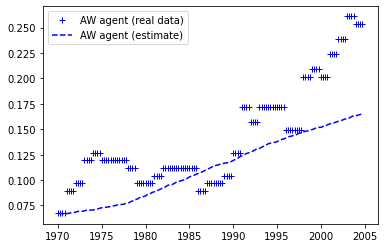

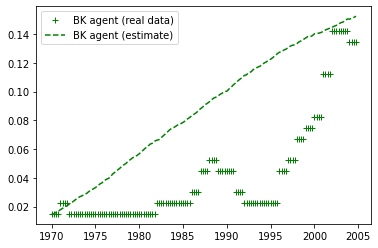

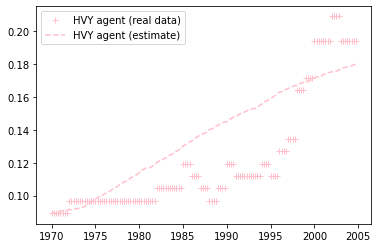

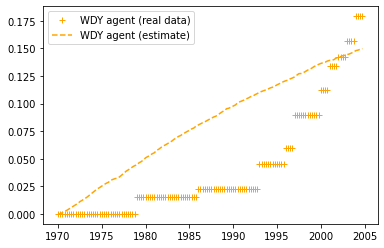

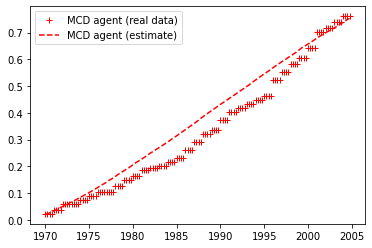

In [ ]:
import matplotlib.pyplot as plt
year = np.arange(TimeLength,dtype=int)/4+1970

# plt.plot(year,Ni_mcd.reshape([-1,35])[0],'b+')

# plt.plot(year,np.average(ostate1.T[0*Nsub*NX:(0+1)*Nsub*NX],axis=0),'g+')

# plt.plot(year,Ni_other[tertile_other==mk].reshape([-1,35])[0],'bo')

# plt.plot(year,np.average(ostate2.T[0*Nsub*NX:(0+1)*Nsub*NX],axis=0),'go')

#for i in range(MTsub):
plt.plot(year,np.mean(Ni_aw.reshape([-1,TimeLength]),axis=0),'b+',label='AW agent (real data)')
plt.plot(year,np.mean(ostate2,axis=1),'b--',label='AW agent (estimate)')
#plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_bk.reshape([-1,TimeLength]),axis=0),'g+',label='BK agent (real data)')
plt.plot(year,np.mean(ostate3,axis=1),'g--',label='BK agent (estimate)')
#plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_hvy.reshape([-1,TimeLength]),axis=0),'+',color='pink',label='HVY agent (real data)')
plt.plot(year,np.mean(ostate4,axis=1),'--',color='pink',label='HVY agent (estimate)')
#plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_wdy.reshape([-1,TimeLength]),axis=0),'+',color = 'orange',label='WDY agent (real data)')
plt.plot(year,np.mean(ostate5,axis=1),'--',color='orange',label='WDY agent (estimate)')
#plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_mcd.reshape([-1,TimeLength]),axis=0),'r+',label='MCD agent (real data)')
plt.plot(year,np.mean(ostate1,axis=1),'r--',label='MCD agent (estimate)')
#plt.ylim(0,0.8)
plt.legend()
plt.show()

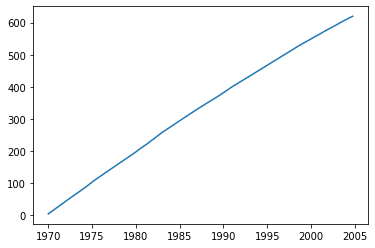

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# a1_true = np.kron(ai_mcd.reshape([-1,35]).T,np.ones(Nsub*NX))
# a2_true = np.kron(ai_other[tertile_other==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# ob1_true = np.kron(Ni_mcd.reshape([-1,35]).T,np.ones(Nsub*NX))
# ob2_true = np.kron(Ni_other[tertile_other==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# z_true = np.kron(z_data,np.ones(Nsub*NX))

# mean_squared_error(a1_true.T,action1.T,multioutput='raw_values')
a1_true = ai_mcd.reshape([-1,TimeLength])
a1_est = np.mean(action1.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
a2_true = ai_aw.reshape([-1,TimeLength])
a2_est = np.mean(action2.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
a3_true = ai_bk.reshape([-1,TimeLength])
a3_est = np.mean(action3.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
a4_true = ai_hvy.reshape([-1,TimeLength])
a4_est = np.mean(action4.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
a5_true = ai_wdy.reshape([-1,TimeLength])
a5_est = np.mean(action5.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T

ob1_true = Ni_mcd.reshape([-1,TimeLength])
ob1_est = np.mean(ostate1.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
ob2_true = Ni_aw.reshape([-1,TimeLength])
ob2_est = np.mean(ostate2.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
ob3_true = Ni_bk.reshape([-1,TimeLength])
ob3_est = np.mean(ostate3.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
ob4_true = Ni_hvy.reshape([-1,TimeLength])
ob4_est = np.mean(ostate4.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
ob5_true = Ni_wdy.reshape([-1,TimeLength])
ob5_est = np.mean(ostate5.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
z_true = z_data.T
z_est = np.mean(zstate.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
s1_true = disc_pop.reshape([-1,TimeLength])
s1_est = np.mean(s1state.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
s2_true = disc_inc.reshape([-1,TimeLength])
s2_est = np.mean(s2state.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
s3_true = disc_val.reshape([-1,TimeLength])
s3_est = np.mean(s3state.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T

res = mean_squared_error(a1_true,a1_est,multioutput='raw_values')+\
       mean_squared_error(a2_true,a2_est,multioutput='raw_values')+\
       mean_squared_error(a3_true,a3_est,multioutput='raw_values')+\
       mean_squared_error(a4_true,a4_est,multioutput='raw_values')+\
       mean_squared_error(a5_true,a5_est,multioutput='raw_values')+\
       mean_squared_error(ob1_true,ob1_est,multioutput='raw_values')+\
       mean_squared_error(ob2_true,ob2_est,multioutput='raw_values')+\
       mean_squared_error(ob3_true,ob3_est,multioutput='raw_values')+\
       mean_squared_error(ob4_true,ob4_est,multioutput='raw_values')+\
       mean_squared_error(ob5_true,ob5_est,multioutput='raw_values')+\
       mean_squared_error(z_true,z_est,multioutput='raw_values')+\
       mean_squared_error(s1_true,s1_est,multioutput='raw_values')+\
       mean_squared_error(s2_true,s2_est,multioutput='raw_values')+\
       mean_squared_error(s3_true,s3_est,multioutput='raw_values')

plt_res = []
for i in range(TimeLength):
  plt_res.append(np.sum(res[0:i+1]))
plt.plot(year,plt_res,'-')
plt.show()
# plt_res,res
#np.kron(np.arange(4),np.ones(3)).reshape([4,3])

###7.Result

In [ ]:
print('#############################################################################')
print(res1,res1.fun)#*5*MT)
print(Dynamic(res1.x))
# rranges = [(0.5+lower_bound,1-lower_bound),(0+lower_bound,0.5-lower_bound),
#            (0.5+lower_bound,1-lower_bound),(0.5+lower_bound,1-lower_bound)]
# resbrute = optimize.brute(func1, rranges, finish=None,Ns=10)
# print(resbrute,func1(resbrute))
trans_est = np.zeros([2,2])
trans_est[:,0] = res1.x[0:2]
trans_est[:,1] = 1-trans_est[:,0]
#print(trans_est)
pi_distEst = trans_est.copy()
for i in range(200):
  pi_distEst = pi_distEst.dot(trans_est)
print('----->',pi_distEst[0])

print('#############################################################################')
import numpy as np
print(res22)
print(res22.x*norm_thetaS,res22.fun*5*MT) # 28min
haha = res22.x*norm_thetaS
print('{:.4f}&{:.4f}'.format(haha[0],haha[8]))
print('{:.4f}&{:.4f}'.format(haha[1],haha[9]))
print('{:.4f}&{:.4f}'.format(haha[2],haha[10]))
print('{:.4f}&{:.4f}'.format(haha[3],haha[11]))
print('{:.4f}&{:.4f}'.format(haha[4],haha[12]))
print('{:.4f}&{:.4f}'.format(haha[5],haha[13]))
print('{:.4f}&{:.4f}'.format(haha[6],haha[14]))
print('{:.4f}&{:.4f}'.format(haha[7],haha[15]))
print('#############################################################################')

#############################################################################
      fun: 7247.80807114259
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.36649301e+03, -4.13389516e+03,  1.33695720e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([0.8499    , 0.0251    , 0.93451554]) 7247.80807114259
(array([[0.8499, 0.1501],
       [0.0251, 0.9749]]), array([[0.93451554, 0.06548446],
       [0.06548446, 0.93451554]]))
-----> [0.14326484 0.85673516]
#############################################################################
      fun: 0.041644800766143346
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [

<ipython-input-5-19df66c51375>:12: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  obser[:,0] = [obser_val,1-obser_val]


##Complete

###1. Global transtion F_Ni, F_dz1,F_dz2,F_dz3

In [ ]:
I = 2 #MCD and Other homogenous
J = 3 #Action: 0,1,2
NS = 4**(numstates)
NX_comp = 2
#NZ = obser

F_Ni_comp = np.zeros([I,J,NX_comp,NS,NS])#;
#for i in range(NX_comp): 
F_Ni_comp[0,0] = np.kron(np.array([[1]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) +\
                          [[1]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[1]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [1] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) ),np.ones([NX_comp,1,1]))
F_Ni_comp[0,1] =np.kron(np.array([[1]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) +\
                          [[0]*4**(numstates-1)+[1]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [1] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[1]*4**(numstates-1)]*4**(numstates-1) ),np.ones([NX_comp,1,1]))
F_Ni_comp[0,2] = np.kron(np.array([[0]*4**(numstates-1)+[1]*4**(numstates-1) + [0] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) +\
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [1] *4**(numstates-1)+[0]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[1]*4**(numstates-1)]*4**(numstates-1) + \
                          [[0]*4**(numstates-1)+[0]*4**(numstates-1) + [0] *4**(numstates-1)+[1]*4**(numstates-1)]*4**(numstates-1) ),np.ones([NX_comp,1,1]))
F_Ni_comp[1] = F_Ni_comp[0]

F_dz1_comp = np.kron((fz1_4x4[dz1,:])[:,dz1],np.ones([I,J,NX_comp,1,1]))#; % The transition pattern is common across (i,j,mtype)
F_dz2_comp = np.kron((fz2_4x4[dz2,:])[:,dz2],np.ones([I,J,NX_comp,1,1]))#; % The transition pattern is common across (i,j,mtype)
F_dz3_comp = np.kron((fz3_4x4[dz3,:])[:,dz3],np.ones([I,J,NX_comp,1,1]))#; % The transition pattern is common across (i,j,mtype)

###2. Dynamix and SigmaLambda

In [ ]:
import itertools
dim_hstate = 2
dim_observe = obser
def Dynamic_comp(theta23):
  trans_val = theta23[0:2]
  obser_val = theta23[2:]

  trans = np.zeros([dim_hstate,dim_hstate]) #s_t^h,s_{t+1}^h
  trans[:,0] = trans_val
  trans[:,1] = 1-trans[:,0]
  return trans
# print(Dynamic(np.array([0.95, 0.05])))#, 0.125])))#,0.125]+[0.1])))#,0.1,0.1])))  


### 3. Generate P(nj|policy)

In [ ]:
F_fix_comp = F_Ni_comp * F_dz1_comp * F_dz2_comp *F_dz3_comp
# % Calculate F from P (& global transition matrices F_Ni, F_dz1, F_dz2) 
import time
def updateF_comp(P):
  #% For a given combination of (Ni, dz1, dz2, mtype), make the state indexes (x, x0, x1, x2, x3)
  #% Beliefs: mapping from today's state (Ni,Nj,dz1,dz2) to tomorrow's Nj = {0,1,2,3}
  fnj_mcd = np.zeros([NX_comp,NS,4])#;      % McDonald's belief
  fnj_other = np.zeros([NX_comp,NS,4])#;    % Other 4 chains beliefs

  nj = 0#;         % If today's # of rivals = 0
  x =  (4**4)*Ni + (4**3)*nj + (4**2)*dz1 + 4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 + 4*dz2+dz3#;  % index of today's state for rivals with 0 shops

  fnj_mcd[:,x,0] = P[1,1][:,x0]**4#;                               % Prob(Nj'= 0) from McD's perspective
  fnj_mcd[:,x,1] = 4 * P[1,2][:,x0] * (P[1,1][:,x0]**3)#;       % Prob(Nj'= 1) from McD's perspective
  fnj_mcd[:,x,2] = 6 * (P[1,2][:,x0]**2) * (P[1,1][:,x0]**2)#;   % Prob(Nj'= 2) from McD's perspective
  fnj_mcd[:,x,3] = 4 * (P[1,2][:,x0]**3) * P[1,1][:,x0]#;       % Prob(Nj'= 3) from McD's perspective
  
  fnj_other[:,x,0] = P[0,1][:,x0] * (P[1,1][:,x0]**3)#;         % Prob(Nj'= 0) etc. from Others' perspectives
  fnj_other[:,x,1] = P[0,2][:,x0] * (P[1,1][:,x0]**3) + P[0,1][:,x0] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)#;  
  fnj_other[:,x,2] = P[0,2][:,x0] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2) + P[0,1][:,x0] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0]
  fnj_other[:,x,3] = P[0,2][:,x0] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0] + P[0,1][:,x0] * (P[1,2][:,x0]**3)
  
  nj = 1#;         % If today's # of rivals = 1                               
  x =  (4**4)*Ni + (4**3)*nj + (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 =  (4**4)*1 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  
  fnj_mcd[:,x,0] = P[1,0][:,x1] * (P[1,1][:,x0]**3)#;
  fnj_mcd[:,x,1] = P[1,1][:,x1] * (P[1,1][:,x0]**3)#;
  fnj_mcd[:,x,2] = P[1,2][:,x1] * (P[1,1][:,x0]**3) + P[1,1][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)#;
  fnj_mcd[:,x,3] = P[1,2][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2) + P[1,1][:,x1] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0]
  
  fnj_other[:,x,0] = .5 * (P[0,0][:,x1] * P[1,1][:,x0]**3) + .5 * (P[0,1][:,x0] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,1] = .5 * (P[0,1][:,x1] * P[1,1][:,x0]**3) + .5 * (P[0,1][:,x0] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .5 * (P[0,2][:,x1] * (P[1,1][:,x0]**3) + P[0,1][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2))+\
                              .5 * (P[0,2][:,x0] * P[1,1][:,x1] * (P[1,1][:,x0]**2) +\
                        P[0,1][:,x0] * (P[1,2][:,x1] * (P[1,1][:,x0]**2) + P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]))
  fnj_other[:,x,3] = .5 * (P[0,2][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)\
                        + P[0,1][:,x1] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0])\
                        + .5 * (P[0,2][:,x0] * P[1,2][:,x1] * (P[1,1][:,x0]**2)\
                      + P[0,2][:,x0] * P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]\
                      + P[0,1][:,x0] * P[1,2][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]\
                      + P[0,1][:,x0] * P[1,1][:,x1] * (P[1,2][:,x0]**2))

  nj = 2#;         % If today's # of rivals = 2
  x = (4**4)*Ni + (4**3)*nj + (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 = (4**4)*1 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x2 = (4**4)*2 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 2 shops
  
  fnj_mcd[:,x,0] = (P[1,0][:,x1]**2) * (P[1,1][:,x0]**2)
  fnj_mcd[:,x,1] = (1/3) * (P[1,0][:,x2] * (P[1,1][:,x0]**3)) + (2/3) * (P[1,0][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,2] = (1/3) * (P[1,1][:,x2] * (P[1,1][:,x0]**3)) + (2/3) * ((P[1,1][:,x1]**2) * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,3] = (1/3) * (P[1,2][:,x2] * (P[1,1][:,x0]**3)  + (P[1,1][:,x2] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)))
  
  fnj_other[:,x,0] = .5 * 0 + .5 * (P[0,0][:,x1] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,1] = .5 * (P[0,0][:,x2] * (P[1,1][:,x0]**3))\
      + .5 * (P[0,0][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .5 * (P[0,1][:,x2] * (P[1,1][:,x0]**3))\
      + .5 * (P[0,1][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,3] = .5 * (P[0,2][:,x2] * (P[1,1][:,x0]**3)\
      + P[0,1][:,x2] * 3 * P[1,2][:,x0] * P[1,1][:,x0])\
      + .5 * (P[0,2][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,2][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0])
  
  nj = 3#;         % If today's # of rivals = 3
  x = (4**4)*Ni + (4**3)*nj + (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4**4)*0 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 = (4**4)*1 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x2 = (4**4)*2 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 2 shops
  x3 = (4**4)*3 + (4**3)*Ni + (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 3 shops
  
  fnj_mcd[:,x,0] = (2/3) * (P[1,0][:,x1]**3) * P[1,1][:,x0]
  fnj_mcd[:,x,1] = (2/3) * (P[1,0][:,x1]**2) * P[1,1][:,x1] + (1/3) * P[1,0][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2)
  fnj_mcd[:,x,2] = (2/3) * P[1,0][:,x1] * (P[1,1][:,x1]**2) + (1/3) * (P[1,0][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[1,1][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,3] = (2/3) * (P[1,1][:,x1]**3) * P[1,1][:,x0] + (1/3) * P[1,1][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)
  
  fnj_other[:,x,0] = .25 * (P[0,0][:,x1] * (P[1,0][:,x1]**2) * P[1,1][:,x0])
  fnj_other[:,x,1] = .25 * 0 + .25 * (P[0,0][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,0][:,x1] * 2 * P[1,0][:,x1] * P[1,1][:,x1] * P[1,1][:,x0]\
      + P[0,1][:,x1] * (P[1,0][:,x1]**2) * P[1,1][:,x0])\
      + .25 * (P[0,0][:,x1] * P[1,0][:,x2] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .25 * (P[0,0][:,x3] * (P[1,1][:,x0]**3))\
      + .25 * (P[0,0][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,0][:,x1] * (P[1,1][:,x1]**2) * P[1,1][:,x0]\
      + P[0,1][:,x1] * 2 * P[1,0][:,x1] * P[1,1][:,x1] * P[1,1][:,x0])\
      + .25 * (P[0,0][:,x1] * P[1,1][:,x2] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,0][:,x2] * (P[1,1][:,x0]**2))
  fnj_other[:,x,3] = .25 * (P[0,1][:,x3] * (P[1,1][:,x0]**3))\
      + .25 * (P[0,1][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,1][:,x1] * (P[1,1][:,x1]**2) * P[1,1][:,x0])\
      + .25 * (P[0,1][:,x1] * P[1,1][:,x2] * (P[1,1][:,x0]**2))

  F_Nj = np.ones([I,J,NX_comp,NS,NS])
  Denom_mcd = np.matmul(fnj_mcd,np.ones([NX_comp,4,4]))#np.kron(np.reshape(np.sum(fnj_mcd,axis=2),[NX_comp,-1,1]),np.ones([1,1,4]))#;         % Sum of each row
  fnj_mcd = fnj_mcd / Denom_mcd#;                 % Make sure each row sums up to 1
  fnj_mcd[np.isnan(fnj_mcd)] = 0#;                    % Replace NaN with 0
  F_Nj[0,0] = fnj_mcd[:,:,Nj]

  Denom_other = np.matmul(fnj_other,np.ones([NX_comp,4,4]))#np.kron(np.reshape(np.sum(fnj_other,axis=2),[NX_comp,-1,1]),np.ones([1,1,4]))#;             % Sum of each row
  fnj_other = fnj_other / Denom_other#;                   % Make sure each row sums up to 1
  fnj_other[np.isnan(fnj_other)] = 0#;                        % Replace NaN with 0
  F_Nj[1,0] = fnj_other[:,:,Nj]
  #F_Nj[2:5,j,:,:] = np.stack([F_Nj[1,j,:,:] for copy in range(3)],axis=0)#;    % Other 4 chains are symmetric

  for j in range(1,J):    
      F_Nj[:,j] = F_Nj[:,0]    
  return F_Nj*F_fix_comp

# P_new = 1/J*np.ones([I,J,NX_comp,NS])#softmax(np.arange(I*J*NS).reshape([I,J,NS]),axis=1)
# F_new = updateF_comp(P_new.copy())
# #np.sum(F_new!=0)
# print(F_new.shape)

###4.Value Iteration

In [ ]:
from scipy.special import logsumexp
from scipy.special import softmax

def updatePi_comp(Q):
  P = np.zeros([I,J,NX_comp,NS])#; player, action,NZ, states, Market Type
  P[0] = softmax(Q[0],axis=0)
  P[1] = softmax(Q[1],axis=0)
  P[np.isnan(P)] = 0#;
  return P

def updateQ_comp(thetaS,Q,F,trans,Q_new,beta = 0.9):

  gamma = 0.5772
    
  #v_mcd = np.zeros([J,NX,obser,NS])
  #v_other = np.zeros([J,NX,obser,NS])

  v_mcd= Q[0] # (Agent), action, NZ_new,NS_new
  v_other = Q[1]
  #v_mcd = np.stack([iterpP*Q[0,j][iterf]+(1-iterpP)*Q[0,j][iterc] for j in range(J)],axis=0)
  #v_other = np.stack([iterpP*Q[1,j][iterf]+(1-iterpP)*Q[1,j][iterc] for j in range(J)],axis=0)
  v_mcd = gamma + logsumexp(v_mcd,axis=0) #(action), NZ_new,NS_new
  v_other = gamma + logsumexp(v_other,axis=0)
  v_mcd = trans.dot(v_mcd).reshape([1,NX_comp,NS,1]) #NZ_old,NS_new
  v_other = trans.dot(v_other).reshape([1,NX_comp,NS,1])
  v_mcd = np.kron(v_mcd,np.ones([J,1,1,1])) #a_old,NZ_old,NS_new,1
  v_other = np.kron(v_other,np.ones([J,1,1,1])) #a_old,NZ_old,NS_new,1

  v_temp_mcd = np.matmul(F[0],v_mcd)[:,:,:,0] # action_old,nz_old, ns_old (ns_new \times ns_new)
  v_temp_other = np.matmul(F[1],v_other)[:,:,:,0] 

  Q_new[0] = Q_new[0] + beta*(v_temp_mcd) 
  Q_new[1] = Q_new[1] + beta*(v_temp_other)
  return Q_new

theta23_comp = np.array([0.95, 0.05])#, 0.1,0.9,0.1])#,0.1,0.1])
trans_comp = Dynamic_comp(theta23_comp)



import time

def ValueIteration_comp(thetaS,trans,error = 5e-3,beta = 0.9):
  Pi0 = 1/3*np.ones([I,J,NX_comp,NS])
  F0= updateF_comp(Pi0)
  Q0 = np.zeros([I,J,NX_comp,NS])
  Pi_old = Pi0
  F_old = F0
  Q_old = Q0

  #x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX_comp,NS])
  thetaS_mcd = np.reshape(np.array([thetaS[2],thetaS[3],thetaS[4],thetaS[5],thetaS[6],thetaS[7]]),[-1,1])
  thetaS_other = np.reshape(np.array([thetaS[10],thetaS[11],thetaS[12],thetaS[13],thetaS[14],thetaS[15]]),[-1,1])
  #Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_mcd)
  # print(r_mcd_a2.shape,r_mcd_a2.T[0].shape,Ni.shape)
  R_new[0,2,0] =   r_mcd_a2.T[0] + thetaS[0]*Ni
  R_new[0,2,1] = r_mcd_a2.T[0] + thetaS[1]*Ni

  R_new[0,1,0] =   r_mcd_a1.T[0] + thetaS[0]*Ni
  R_new[0,1,1] = r_mcd_a1.T[0] + thetaS[1]*Ni
  R_new[0,0] = R_new[0,1].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj,Ni*dz1,Ni*dz2,Ni*dz3,  0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2,0] =  r_other_a2.T[0]+ thetaS[8]*Ni   
  R_new[1,2,1] =  r_other_a2.T[0]+ thetaS[9]*Ni   

  R_new[1,1,0] =  r_other_a1.T[0] + thetaS[8]*Ni
  R_new[1,1,1] =  r_other_a1.T[0] + thetaS[9]*Ni

  R_new[1,0] = R_new[1,1].copy()
  error1 = np.inf
  for iter in range(1000):
    # time_start = time.time()
    Q_new = updateQ_comp(thetaS,Q_old,F_old,trans,Q_new = R_new.copy(),beta=beta) #I, J, NS
    Pi_new = updatePi_comp(Q_new)#I,J,NS
    #time_start1 = time.time()
    #print(time_start1-time_start)
    F_new = updateF_comp(Pi_new) # I, J, NS,NS
    #print(time.time()-time_start1)
    if iter>0:
      error1 = np.max(np.abs(Q_new-Q_old))/np.max(np.abs(Q_old))
    # error2 = np.max(np.abs(Pi_new-Pi_old))/np.max(np.abs(Pi_old))
    # error3 = np.max(np.abs(F_new-F_old))/np.max(np.abs(F_old))
    # print('iteration {} --> e1:{:.4f}({:.4f}), e2:{:.4f}({:.4f}), e3:{:.4f}({:.4f}), time:{}'.format(iter,error1,np.max(np.abs(Q_old)),error2,np.max(np.abs(Pi_old)),error3,np.max(np.abs(F_old)),time.time()-time_start))
    # #print('iteration {} --> e1:{},time:{}'.format(iter,error1,time.time()-time_start))

    if error1<error :#and error2<error and error3<error:
      #print('iteration {} --> e1:{},e2:{},e3:{}'.format(iter,error1,error2,error3))
      break
    Q_old = Q_new.copy()
    Pi_old = Pi_new.copy()
    F_old = F_new.copy()
  return Q_new, Pi_new,F_new

# thetaS_comp = np.array([1.59964766,  3.24167367, -1.14118353, -0.57127046, 0,0,0, 7.94657815,
#         1.20992736,  1.8540286 , -0.56174424, -0.22402731, 0,0,0, 7.48219509])
# # #thetaS = np.zeros(5*2)
# Q_new_comp, Pi_new_comp,F_new_comp = ValueIteration_comp(thetaS_comp,trans_comp)

###5. log-likelihood (Complete)

In [ ]:
from scipy.optimize import minimize
lower_bound = 1e-4
# a1 = None#0.8993 # None#
# a2 = 0.008  #None#
def func1_comp(theta23):
  # if a1!=None:
  #   theta23 = np.hstack([[a1,a2],theta23])
  # theta23[0],theta23[1] = 0.8993,0.008
  trans = Dynamic_comp(theta23)
  #sigma_val[np.isnan(sigma_val)] = 0
  res = -np.sum(np.log(trans[z_data[0:-1],z_data[1:]]))

  print(theta23,res)
  return res #/(5*MT)

from scipy import optimize
init_x0 = np.array([0.8993,0.008])# ,0.53673132])#, 1-2*lower_bound, 2*lower_bound])#theta23
rranges = [(0+lower_bound,1-lower_bound),(0+lower_bound,1-lower_bound)]
print('start from:',init_x0)
cons=[{'type':'ineq', 'fun': lambda x: 1-x[2]-x[3]-x[4]},
      {'type':'ineq', 'fun': lambda x: 1-x[5]-x[6]-x[7]},
      {'type':'ineq', 'fun': lambda x: x[3]-x[6]}]
res1_comp = minimize(func1_comp,init_x0,bounds = rranges)#,constraints=cons)#,options={'maxiter':1000},tol=1e-5)
print(res1_comp,res1_comp.fun)#*5*MT)
print(Dynamic_comp(res1_comp.x))
# rranges = [(0.5+lower_bound,1-lower_bound),(0+lower_bound,0.5-lower_bound),
#            (0.5+lower_bound,1-lower_bound),(0.5+lower_bound,1-lower_bound)]
# resbrute = optimize.brute(func1, rranges, finish=None,Ns=10)
# print(resbrute,func1(resbrute))
trans_est_comp = np.zeros([2,2])
trans_est_comp[:,0] = res1_comp.x[0:2]
trans_est_comp[:,1] = 1-trans_est_comp[:,0]
#print(trans_est)
pi_distEst_comp = trans_est_comp.copy()
for i in range(200):
  pi_distEst_comp = pi_distEst_comp.dot(trans_est_comp)
print('----->',pi_distEst_comp[0])
# [[0.94       0.06      ]
#  [0.00813008 0.99186992]]
# -----> [0.11933235 0.88066765

start from: [0.8993 0.008 ]
[0.8993 0.008 ] 11723.653167596329
[0.89930001 0.008     ] 11723.653310888036
[0.8993     0.00800001] 11723.651298081453
[1.000e-04 9.999e-01] 141931.66674823558
[1.0001e-04 9.9990e-01] 141931.51937168668
[1.0000000e-04 9.9989999e-01] 141930.2732339856
[0.46421932 0.48793386] 12615.832474616192
[0.46421933 0.48793386] 12615.83247287624
[0.46421932 0.48793387] 12615.832713813252
[0.74817931 0.17469996] 8126.400384663246
[0.74817932 0.17469996] 8126.400428817049
[0.74817931 0.17469997] 8126.40046147953
[0.74375917 0.17132391] 8081.641288479825
[0.74375918 0.17132391] 8081.641331415047
[0.74375917 0.17132392] 8081.641362794384
[0.72607858 0.15781968] 7916.56176133878
[0.72607859 0.15781968] 7916.5617997409145
[0.72607858 0.15781969] 7916.561824925604
[0.59243698 0.07063423] 7497.369781699011
[0.59243699 0.07063423] 7497.369796272748
[0.59243698 0.07063424] 7497.369703999086
[0.60383687 0.10287366] 7402.32746935827
[0.60383688 0.10287366] 7402.327485537045
[0.60

In [ ]:
norm_thetaS = 1
trans_comp = Dynamic_comp(res1_comp.x)
z_data_old = z_data.T.reshape(-1)
def func_comp(thetaS,trans=trans_comp):
  _, Pi_new,_ = ValueIteration_comp(thetaS*norm_thetaS,trans)
  #print(np.unique(a_mcd))
  res = -np.sum(np.log(  Pi_new[0,ai_mcd,z_data_old,stateID_mcd]))
  res = res -np.sum(np.log(  Pi_new[1,ai_other,np.hstack([z_data_old for i in range(4)]),stateID_other]))
  print(thetaS*norm_thetaS,res)
  return res/5/MT
from scipy.optimize import minimize

thetaS_comp = np.array([1.92097473,  1.99265921, -0.4827623 , -0.07733517,  0.04555352,
        0.04501307,  0.04442598, 12.7330296 ,  1.14319858,  1.69140101,
       -0.46360043, -0.10918738,  0.01787647,  0.03823987,  0.0412867 ,
       10.39515777])

print('start from:',thetaS_comp*norm_thetaS )
res22_comp = minimize(func_comp,thetaS_comp,options={'maxiter':4000},tol=5e-5)
print(res22_comp)
print(res22_comp.x*norm_thetaS,res22_comp.fun*5*MT) # 28min

start from: [ 1.92097473  1.99265921 -0.4827623  -0.07733517  0.04555352  0.04501307
  0.04442598 12.7330296   1.14319858  1.69140101 -0.46360043 -0.10918738
  0.01787647  0.03823987  0.0412867  10.39515777]
[ 1.92097473  1.99265921 -0.4827623  -0.07733517  0.04555352  0.04501307
  0.04442598 12.7330296   1.14319858  1.69140101 -0.46360043 -0.10918738
  0.01787647  0.03823987  0.0412867  10.39515777] 58303.64497531033
[ 1.92097474  1.99265921 -0.4827623  -0.07733517  0.04555352  0.04501307
  0.04442598 12.7330296   1.14319858  1.69140101 -0.46360043 -0.10918738
  0.01787647  0.03823987  0.0412867  10.39515777] 58303.64497528243
[ 1.92097473  1.99265922 -0.4827623  -0.07733517  0.04555352  0.04501307
  0.04442598 12.7330296   1.14319858  1.69140101 -0.46360043 -0.10918738
  0.01787647  0.03823987  0.0412867  10.39515777] 58303.64497521036
[ 1.92097473  1.99265921 -0.48276229 -0.07733517  0.04555352  0.04501307
  0.04442598 12.7330296   1.14319858  1.69140101 -0.46360043 -0.10918738
  0.

In [ ]:
import numpy as np

haha = res22_comp.x*norm_thetaS
print('{:.4f}&{:.4f}'.format(haha[0],haha[8]))
print('{:.4f}&{:.4f}'.format(haha[1],haha[9]))
print('{:.4f}&{:.4f}'.format(haha[2],haha[10]))
print('{:.4f}&{:.4f}'.format(haha[3],haha[11]))
print('{:.4f}&{:.4f}'.format(haha[4],haha[12]))
print('{:.4f}&{:.4f}'.format(haha[5],haha[13]))
print('{:.4f}&{:.4f}'.format(haha[6],haha[14]))
print('{:.4f}&{:.4f}'.format(haha[7],haha[15]))





1.9210&1.1432
1.9927&1.6914
-0.4828&-0.4636
-0.0773&-0.1092
0.0456&0.0179
0.0450&0.0382
0.0444&0.0413
12.7330&10.3952


###6.MSE

In [ ]:
from tqdm import tqdm
#Nsub = 5*10
#MTsub = int(len(ai_mcd)/TimeLength)

dim_a = 3
dy_aiso = np.zeros([dim_a,4,4])
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_aiso[ai,ni_old,ni_new] = 1
dy_aiso[0,0,0] = 1
dy_aiso[2,3,3] = 1
print(NX)
def DataGeneration_comp(theta1 = res22_comp.x,theta23=res1_comp.x,T=TimeLength,N=int(Nsub*NX*MTsub),Nsub = Nsub,num=NX):



  trans = Dynamic_comp(theta23)
  _, Pi_new,_ = ValueIteration_comp(theta1,trans)
  pi1 = Pi_new[0]#Action,belief,state
  pi2 = Pi_new[1]

  ostate1 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n1)
  ostate2 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate3 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate4 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate5 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)

  zstate = np.zeros([T,N],dtype = int)   #observation state z
  s1state = np.zeros([T,N],dtype = int)   #population state z
  s2state = np.zeros([T,N],dtype = int)   #income state z
  s3state = np.zeros([T,N],dtype = int)   #property value state z

  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action
  action3 = np.zeros([T,N],dtype = int)   #agent2's action
  action4 = np.zeros([T,N],dtype = int)   #agent2's action
  action5 = np.zeros([T,N],dtype = int)   #agent2's action

  zstate[0,:] = np.int_(np.kron(z_data[0],
                                np.ones(Nsub*num,dtype = int)))#np.int_(obser[hstate[0],0]<=zstate_mat) # random generate income
  s1state[0,:] = np.int_(np.kron(disc_pop.reshape([-1,TimeLength]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  s2state[0,:] = np.int_(np.kron(disc_val.reshape([-1,TimeLength]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  s3state[0,:] = np.int_(np.kron(disc_inc.reshape([-1,TimeLength]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate1[0,:] = np.int_(np.kron(Ni_mcd.reshape([-1,TimeLength]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  ostate2[0,:] = np.int_(np.kron(Ni_aw.reshape([-1,TimeLength]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate3[0,:] = np.int_(np.kron(Ni_bk.reshape([-1,TimeLength]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate4[0,:] = np.int_(np.kron(Ni_hvy.reshape([-1,TimeLength]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate5[0,:] = np.int_(np.kron(Ni_wdy.reshape([-1,TimeLength]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  action1[0,:] = np.int_(np.kron(ai_mcd.reshape([-1,TimeLength]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action2[0,:] = np.int_(np.kron(ai_aw.reshape([-1,TimeLength]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action3[0,:] = np.int_(np.kron(ai_bk.reshape([-1,TimeLength]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action4[0,:] = np.int_(np.kron(ai_hvy.reshape([-1,TimeLength]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action5[0,:] = np.int_(np.kron(ai_wdy.reshape([-1,TimeLength]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)

  for t in tqdm(range(T-1)):
    
    # generate new hidden state and observation state
    zstate_mat = np.random.random(size=N)
    zstate[t+1,:] = np.int_(trans[zstate[t,:],0]<=zstate_mat) # random generate income
    s1state_mat = np.random.random(size=N)
    ps11 = fz1_4x4[s1state[t],0]
    ps12 = fz1_4x4[s1state[t],1]
    ps13 = fz1_4x4[s1state[t],2]
    s1state[t+1,:] = np.int_(ps11<=s1state_mat) + np.int_(ps11 + ps12 <= s1state_mat) + np.int_(ps11 + ps12 + ps13 <= s1state_mat)
    s2state_mat = np.random.random(size=N)
    ps21 = fz2_4x4[s2state[t],0]
    ps22 = fz2_4x4[s2state[t],1]
    ps23 = fz2_4x4[s2state[t],2]
    s2state[t+1,:] = np.int_(ps21<=s2state_mat) + np.int_(ps21 + ps22 <= s2state_mat) + np.int_(ps21 + ps22 + ps23 <= s2state_mat)
    s3state_mat = np.random.random(size=N)
    ps31 = fz3_4x4[s3state[t],0]
    ps32 = fz3_4x4[s3state[t],1]
    ps33 = fz3_4x4[s3state[t],2]
    s3state[t+1,:] = np.int_(ps31<=s3state_mat) + np.int_(ps31 + ps32 <= s3state_mat) + np.int_(ps31 + ps32 + ps33 <= s3state_mat)

    ostate1[t+1,:] = np.int_(np.where(dy_aiso[action1[t],ostate1[t],:]==1)[1])#n1
    ostate2[t+1,:] = np.int_(np.where(dy_aiso[action2[t],ostate2[t],:]==1)[1])#n2
    ostate3[t+1,:] = np.int_(np.where(dy_aiso[action3[t],ostate3[t],:]==1)[1])#n2
    ostate4[t+1,:] = np.int_(np.where(dy_aiso[action4[t],ostate4[t],:]==1)[1])#n2
    ostate5[t+1,:] = np.int_(np.where(dy_aiso[action5[t],ostate5[t],:]==1)[1])#n2

    # generate new action for both agents
    osj_aw = ostate3[t+1,:] + ostate4[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_bk = ostate2[t+1,:] + ostate4[t+1,:] + ostate1[t+1,:] + ostate5[t+1,:]
    osj_hvy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_mcd = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate5[t+1,:]
    osj_wdy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate1[t+1,:]
    osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
    osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
    osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
    osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
    osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

    os1 = np.int_(ostate1[t+1,:]*4**4 +osj_mcd*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os2 = np.int_(ostate2[t+1,:]*4**4 + osj_aw*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os3 = np.int_(ostate3[t+1,:]*4**4 +osj_bk*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os4 = np.int_(ostate4[t+1,:]*4**4 + osj_hvy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )
    os5 = np.int_(ostate5[t+1,:]*4**4 +osj_wdy*4**3 + s1state[t+1,:]*4**2+ s2state[t+1,:]*4+ s3state[t+1,:] )


    action_mat1 = np.random.random(size=N)
    p11 = pi1[0,zstate[t+1,:],os1]
    p12 = pi1[1,zstate[t+1,:],os1] 
    action1[t+1,:] = np.int_(p11<=action_mat1) + np.int_(p12 + p11 <= action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = pi2[0,zstate[t+1,:],os2] 
    p22 = pi2[1,zstate[t+1,:],os2] 
    action2[t+1,:] = np.int_(p21<=action_mat2) + np.int_(p22 + p21 <= action_mat2)
    
    action_mat3 = np.random.random(size=N)
    p31 = pi2[0,zstate[t+1,:],os3] 
    p32 = pi2[1,zstate[t+1,:],os3] 
    action3[t+1,:] = np.int_(p31<=action_mat3) + np.int_(p32 + p31 <= action_mat3)

    action_mat4 = np.random.random(size=N)
    p41 = pi2[0,zstate[t+1,:],os4] 
    p42 = pi2[1,zstate[t+1,:],os4] 
    action4[t+1,:] = np.int_(p41<=action_mat4) + np.int_(p42 + p41 <= action_mat4)

    action_mat5 = np.random.random(size=N)
    p51 = pi2[0,zstate[t+1,:],os5] 
    p52 = pi2[1,zstate[t+1,:],os5] 
    action5[t+1,:] = np.int_(p51<=action_mat5) + np.int_(p52 + p51 <= action_mat5)
  return ostate1,ostate2,ostate3,ostate4,ostate5, zstate,s1state,s2state,s3state,action1,action2,action3,action4,action5


ostate1_comp,ostate2_comp,ostate3_comp,ostate4_comp,ostate5_comp, zstate_comp,s1state_comp,s2state_comp,s3state_comp,action1_comp,action2_comp,action3_comp,action4_comp,action5_comp= DataGeneration_comp()

15


100%|██████████| 139/139 [00:01<00:00, 82.73it/s]


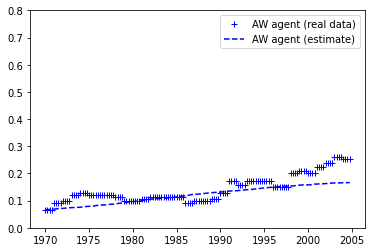

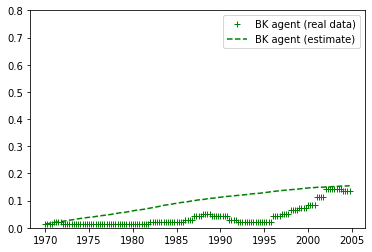

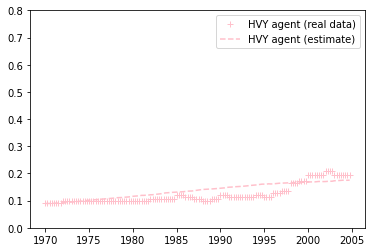

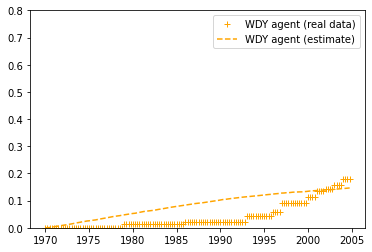

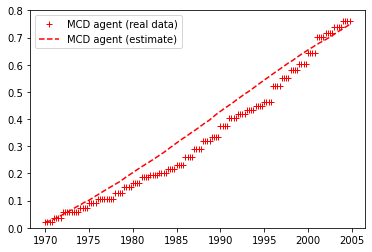

In [ ]:
import matplotlib.pyplot as plt
year = np.arange(TimeLength,dtype=int)/4+1970

# plt.plot(year,Ni_mcd.reshape([-1,35])[0],'b+')

# plt.plot(year,np.average(ostate1.T[0*Nsub*NX:(0+1)*Nsub*NX],axis=0),'g+')

# plt.plot(year,Ni_other[tertile_other==mk].reshape([-1,35])[0],'bo')

# plt.plot(year,np.average(ostate2.T[0*Nsub*NX:(0+1)*Nsub*NX],axis=0),'go')

#for i in range(MTsub):
plt.plot(year,np.mean(Ni_aw.reshape([-1,TimeLength]),axis=0),'b+',label='AW agent (real data)')
plt.plot(year,np.mean(ostate2_comp,axis=1),'b--',label='AW agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_bk.reshape([-1,TimeLength]),axis=0),'g+',label='BK agent (real data)')
plt.plot(year,np.mean(ostate3_comp,axis=1),'g--',label='BK agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_hvy.reshape([-1,TimeLength]),axis=0),'+',color='pink',label='HVY agent (real data)')
plt.plot(year,np.mean(ostate4_comp,axis=1),'--',color='pink',label='HVY agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_wdy.reshape([-1,TimeLength]),axis=0),'+',color = 'orange',label='WDY agent (real data)')
plt.plot(year,np.mean(ostate5_comp,axis=1),'--',color='orange',label='WDY agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_mcd.reshape([-1,TimeLength]),axis=0),'r+',label='MCD agent (real data)')
plt.plot(year,np.mean(ostate1_comp,axis=1),'r--',label='MCD agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()

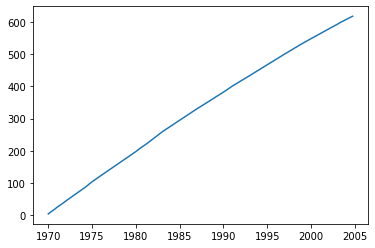

In [ ]:
from sklearn.metrics import mean_squared_error

# a1_true = np.kron(ai_mcd.reshape([-1,35]).T,np.ones(Nsub*NX))
# a2_true = np.kron(ai_other[tertile_other==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# ob1_true = np.kron(Ni_mcd.reshape([-1,35]).T,np.ones(Nsub*NX))
# ob2_true = np.kron(Ni_other[tertile_other==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# z_true = np.kron(z_data,np.ones(Nsub*NX))

# mean_squared_error(a1_true.T,action1.T,multioutput='raw_values')
# a1_true = ai_mcd.reshape([-1,TimeLength])
a1_est_comp = np.mean(action1_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
# a2_true = ai_aw.reshape([-1,TimeLength])
a2_est_comp = np.mean(action2_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
# a3_true = ai_bk.reshape([-1,TimeLength])
a3_est_comp = np.mean(action3_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
# a4_true = ai_hvy.reshape([-1,TimeLength])
a4_est_comp = np.mean(action4_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
# a5_true = ai_wdy.reshape([-1,TimeLength])
a5_est_comp = np.mean(action5_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T

# ob1_true = Ni_mcd.reshape([-1,TimeLength])
ob1_est_comp = np.mean(ostate1_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
# ob2_true = Ni_aw.reshape([-1,TimeLength])
ob2_est_comp = np.mean(ostate2_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
# ob3_true = Ni_bk.reshape([-1,TimeLength])
ob3_est_comp = np.mean(ostate3_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
# ob4_true = Ni_hvy.reshape([-1,TimeLength])
ob4_est_comp = np.mean(ostate4_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
# ob5_true = Ni_wdy.reshape([-1,TimeLength])
ob5_est_comp = np.mean(ostate5_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
# z_true = z_data.T
z_est_comp = np.mean(zstate_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T

# s1_true = disc_pop[tertile==mk].reshape([-1,35])
s1_est_comp = np.mean(s1state_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
# s2_true = disc_inc[tertile==mk].reshape([-1,35])
s2_est_comp = np.mean(s2state_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T
# s3_true = disc_val[tertile==mk].reshape([-1,35])
s3_est_comp = np.mean(s3state_comp.reshape([TimeLength,MTsub,NX*Nsub]),axis=2).T

#res_comp = np.zeros(TimeLength)
res_comp = mean_squared_error(a1_true,a1_est_comp,multioutput='raw_values')+\
           mean_squared_error(a2_true,a2_est_comp,multioutput='raw_values')+\
           mean_squared_error(a3_true,a3_est_comp,multioutput='raw_values')+\
           mean_squared_error(a4_true,a4_est_comp,multioutput='raw_values')+\
           mean_squared_error(a5_true,a5_est_comp,multioutput='raw_values')+\
           mean_squared_error(ob1_true,ob1_est_comp,multioutput='raw_values')+\
           mean_squared_error(ob2_true,ob2_est_comp,multioutput='raw_values')+\
           mean_squared_error(ob3_true,ob3_est_comp,multioutput='raw_values')+\
           mean_squared_error(ob4_true,ob4_est_comp,multioutput='raw_values')+\
           mean_squared_error(ob5_true,ob5_est_comp,multioutput='raw_values')+\
           mean_squared_error(z_true,z_est_comp,multioutput='raw_values')+\
           mean_squared_error(s1_true,s1_est_comp,multioutput='raw_values')+\
           mean_squared_error(s2_true,s2_est_comp,multioutput='raw_values')+\
           mean_squared_error(s3_true,s3_est_comp,multioutput='raw_values')
# res_comp += mean_squared_error(s2_true,s2_est_comp,multioutput='raw_values')
# res_comp += mean_squared_error(s3_true,s3_est_comp,multioutput='raw_values')
plt_res_comp = []
for i in range(TimeLength):
  plt_res_comp.append(np.sum(res_comp[0:i+1]))
plt.plot(year,plt_res_comp,'-')
# plt_res,res
#np.kron(np.arange(4),np.ones(3)).reshape([4,3])


###7.Result

In [ ]:
print('#############################################################################')
print(res1_comp,res1_comp.fun)#*5*MT)
print(Dynamic_comp(res1_comp.x))
# rranges = [(0.5+lower_bound,1-lower_bound),(0+lower_bound,0.5-lower_bound),
#            (0.5+lower_bound,1-lower_bound),(0.5+lower_bound,1-lower_bound)]
# resbrute = optimize.brute(func1, rranges, finish=None,Ns=10)
# print(resbrute,func1(resbrute))
trans_est_comp = np.zeros([2,2])
trans_est_comp[:,0] = res1_comp.x[0:2]
trans_est_comp[:,1] = 1-trans_est_comp[:,0]
#print(trans_est)
pi_distEst_comp = trans_est_comp.copy()
for i in range(200):
  pi_distEst_comp = pi_distEst_comp.dot(trans_est_comp)
print('----->',pi_distEst_comp[0])

print('#############################################################################')
import numpy as np
print(res22_comp)
print(res22_comp.x*norm_thetaS,res22_comp.fun*5*MT) # 28min
haha = res22_comp.x*norm_thetaS
print('{:.4f}&{:.4f}'.format(haha[0],haha[8]))
print('{:.4f}&{:.4f}'.format(haha[1],haha[9]))
print('{:.4f}&{:.4f}'.format(haha[2],haha[10]))
print('{:.4f}&{:.4f}'.format(haha[3],haha[11]))
print('{:.4f}&{:.4f}'.format(haha[4],haha[12]))
print('{:.4f}&{:.4f}'.format(haha[5],haha[13]))
print('{:.4f}&{:.4f}'.format(haha[6],haha[14]))
print('{:.4f}&{:.4f}'.format(haha[7],haha[15]))
print('#############################################################################')

#############################################################################
      fun: 7303.210115809583
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01818989,  0.02846718])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 10
     njev: 14
   status: 0
  success: True
        x: array([0.47825939, 0.10344844]) 7303.210115809583
[[0.47825939 0.52174061]
 [0.10344844 0.89655156]]
-----> [0.16546746 0.83453254]
#############################################################################
      fun: 0.04164546069665023
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Comparison

In [ ]:
l1_partial = -res1.fun +np.sum(np.log(fz1_4x4[disc_pop_mx[:,0:-1],disc_pop_mx[:,1:]])) +\
            np.sum(np.log(fz2_4x4[disc_val_mx[:,0:-1],disc_val_mx[:,1:]])) +\
            np.sum(np.log(fz3_4x4[disc_inc_mx[:,0:-1],disc_inc_mx[:,1:]]))
l2_partial = -res22.fun*5*MT
l1_complete = -res1_comp.fun+np.sum(np.log(fz1_4x4[disc_pop_mx[:,0:-1],disc_pop_mx[:,1:]])) +\
            np.sum(np.log(fz2_4x4[disc_val_mx[:,0:-1],disc_val_mx[:,1:]])) +\
            np.sum(np.log(fz3_4x4[disc_inc_mx[:,0:-1],disc_inc_mx[:,1:]])) 
l2_complete = -res22_comp.fun*5*MT
print('       Partial  &   Complete  & Improvment(%)')
print('l1:  {:.4f} &  {:.4f} & {:.4f}%'.format(l1_partial,l1_complete,(l1_complete-l1_partial)/l1_complete*100))
print('l2: {:.4f} & {:.4f} & {:.4f}%'.format(l2_partial,l2_complete,(l2_complete-l2_partial)/l2_complete*100))
l_partial = l1_partial+l2_partial
l_complete = l1_complete+l2_complete
print('l : {:.4f} & {:.4f} & {:.4f}%'.format(l_partial,l_complete,(l_complete-l_partial)/l_complete*100))

       Partial  &   Complete  & Improvment(%)
l1:  -11507.0076 &  -11562.4096 & 0.4792%
l2: -58302.7211 & -58303.6450 & 0.0016%
l : -69809.7287 & -69866.0546 & 0.0806%


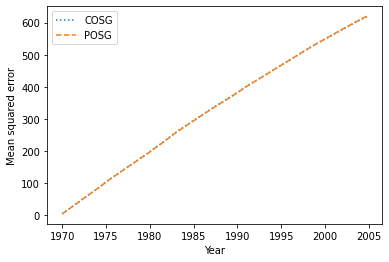

619.9043273631839 618.4230069651742


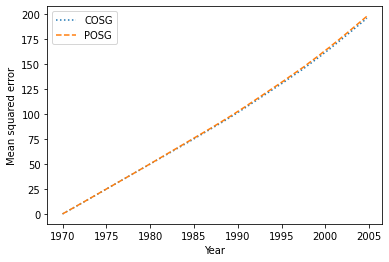

198.01582719734654 196.01162520729682


In [ ]:
plt.plot(year,plt_res_comp,':',label='COSG')
plt.plot(year,plt_res,'--',label="POSG")
plt.ylabel('Mean squared error')
plt.xlabel('Year')
plt.legend()
plt.show()
print(plt_res[-1],plt_res_comp[-1])

res_z = mean_squared_error(a1_true,a1_est,multioutput='raw_values')+\
mean_squared_error(a2_true,a2_est,multioutput='raw_values')+\
mean_squared_error(a3_true,a3_est,multioutput='raw_values')+\
mean_squared_error(a4_true,a4_est,multioutput='raw_values')+\
mean_squared_error(a5_true,a5_est,multioutput='raw_values')+\
mean_squared_error(ob1_true,ob1_est,multioutput='raw_values')+\
mean_squared_error(ob2_true,ob2_est,multioutput='raw_values')+\
mean_squared_error(ob3_true,ob3_est,multioutput='raw_values')+\
mean_squared_error(ob4_true,ob4_est,multioutput='raw_values')+\
mean_squared_error(ob5_true,ob5_est,multioutput='raw_values')#+\
#mean_squared_error(z_true,z_est,multioutput='raw_values')
plt_res_z = []
for i in range(TimeLength):
  plt_res_z.append(np.sum(res_z[0:i+1]))

res_z_comp = mean_squared_error(a1_true,a1_est_comp,multioutput='raw_values')+\
mean_squared_error(a2_true,a2_est_comp,multioutput='raw_values')+\
mean_squared_error(a3_true,a3_est_comp,multioutput='raw_values')+\
mean_squared_error(a4_true,a4_est_comp,multioutput='raw_values')+\
mean_squared_error(a5_true,a5_est_comp,multioutput='raw_values')+\
mean_squared_error(ob1_true,ob1_est_comp,multioutput='raw_values')+\
mean_squared_error(ob2_true,ob2_est_comp,multioutput='raw_values')+\
mean_squared_error(ob3_true,ob3_est_comp,multioutput='raw_values')+\
mean_squared_error(ob4_true,ob4_est_comp,multioutput='raw_values')+\
mean_squared_error(ob5_true,ob5_est_comp,multioutput='raw_values')#+\
#mean_squared_error(z_true,z_est_comp,multioutput='raw_values')
plt_res_z_comp = []
for i in range(TimeLength):
  plt_res_z_comp.append(np.sum(res_z_comp[0:i+1]))

plt.plot(year,plt_res_z_comp,':',label='COSG')
plt.plot(year,plt_res_z,'--',label="POSG")
plt.ylabel('Mean squared error')
plt.xlabel('Year')
plt.legend()
plt.show()
print(plt_res_z[-1],plt_res_z_comp[-1])

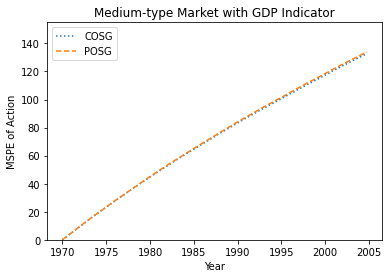

133.8454587064676 132.6535701492537


In [ ]:
res_z = mean_squared_error(a1_true,a1_est,multioutput='raw_values')+\
mean_squared_error(a2_true,a2_est,multioutput='raw_values')+\
mean_squared_error(a3_true,a3_est,multioutput='raw_values')+\
mean_squared_error(a4_true,a4_est,multioutput='raw_values')+\
mean_squared_error(a5_true,a5_est,multioutput='raw_values')
#mean_squared_error(ob5_true,ob5_est,multioutput='raw_values')
#mean_squared_error(a5_true,a5_est,multioutput='raw_values')
#mean_squared_error(z_true,z_est,multioutput='raw_values')
plt_res_z = []
for i in range(TimeLength):
  plt_res_z.append(np.sum(res_z[0:i+1]))

res_z_comp = mean_squared_error(a1_true,a1_est_comp,multioutput='raw_values')+\
mean_squared_error(a2_true,a2_est_comp,multioutput='raw_values')+\
mean_squared_error(a3_true,a3_est_comp,multioutput='raw_values')+\
mean_squared_error(a4_true,a4_est_comp,multioutput='raw_values')+\
mean_squared_error(a5_true,a5_est_comp,multioutput='raw_values')
#mean_squared_error(ob5_true,ob5_est_comp,multioutput='raw_values')
#mean_squared_error(a5_true,a5_est_comp,multioutput='raw_values')
#mean_squared_error(z_true,z_est_comp,multioutput='raw_values')
plt_res_z_comp = []
for i in range(TimeLength):
  plt_res_z_comp.append(np.sum(res_z_comp[0:i+1]))
title_mk ={1:'Low',2:'Medium',3:'High'}
economy_ind = {True:'GDP',False:'INF'}
plt.plot(year,plt_res_z_comp,':',label='COSG')
plt.plot(year,plt_res_z,'--',label="POSG")
plt.ylabel('MSPE of Action')
plt.ylim(0,155)

plt.xlabel('Year')
plt.legend()
plt.title(title_mk[mk]+'-type Market with '+economy_ind[gdp_true]+' Indicator')
save_pic = '/content/drive/MyDrive/2022_Fall/Research_Burger/Final_Burger_Quarter/Picture/'
plt.savefig( save_pic+'Mk'+title_mk[mk]+'_EI'+economy_ind[gdp_true]+'_Dim256.png',dpi=300)
plt.show()
print(plt_res_z[-1],plt_res_z_comp[-1])

In [ ]:
from sklearn.metrics import precision_score
#from sklearn import compute_sample_weight

#sw = compute_sample_weight(class_weight = 'balance',y=a1_est_comp)
#cm = confusion_matrix(a1_true, a1_est_comp, sample_weight=sw)

posg_a1 = precision_score(np.stack([a1_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action1.reshape(-1), average="weighted")
posg_a2 = precision_score(np.stack([a2_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action2.reshape(-1), average="weighted")
posg_a3 = precision_score(np.stack([a3_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action3.reshape(-1), average="weighted")
posg_a4 = precision_score(np.stack([a4_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action4.reshape(-1), average="weighted")
posg_a5 = precision_score(np.stack([a5_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action5.reshape(-1), average="weighted")
cosg_a1 = precision_score(np.stack([a1_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action1_comp.reshape(-1), average="weighted")
cosg_a2 = precision_score(np.stack([a2_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action2_comp.reshape(-1), average="weighted")
cosg_a3 = precision_score(np.stack([a3_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action3_comp.reshape(-1), average="weighted")
cosg_a4 = precision_score(np.stack([a4_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action4_comp.reshape(-1), average="weighted")
cosg_a5 = precision_score(np.stack([a5_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action5_comp.reshape(-1), average="weighted")
print(posg_a1,posg_a2,posg_a3,posg_a4,posg_a5)
print(cosg_a1,cosg_a2,cosg_a3,cosg_a4,cosg_a5)
print((posg_a1+posg_a2+posg_a3+posg_a4+posg_a5)/5)
print((cosg_a1+cosg_a2+cosg_a3+cosg_a4+cosg_a5)/5)

0.9889008836694559 0.9912355802055413 0.9960704023466436 0.9954097513035827 0.9969963058201387
0.9888123974319868 0.9912183650345185 0.996079029155258 0.9954193699913945 0.9969829642989066
0.9937225846690723
0.9937024251824129


In [ ]:
from sklearn.metrics import precision_score
#from sklearn import compute_sample_weight

#sw = compute_sample_weight(class_weight = 'balance',y=a1_est_comp)
#cm = confusion_matrix(a1_true, a1_est_comp, sample_weight=sw)

posg_a1 = precision_score(np.stack([a1_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action1.reshape(-1), average="micro")
posg_a2 = precision_score(np.stack([a2_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action2.reshape(-1), average="micro")
posg_a3 = precision_score(np.stack([a3_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action3.reshape(-1), average="micro")
posg_a4 = precision_score(np.stack([a4_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action4.reshape(-1), average="micro")
posg_a5 = precision_score(np.stack([a5_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action5.reshape(-1), average="micro")
cosg_a1 = precision_score(np.stack([a1_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action1_comp.reshape(-1), average="micro")
cosg_a2 = precision_score(np.stack([a2_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action2_comp.reshape(-1), average="micro")
cosg_a3 = precision_score(np.stack([a3_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action3_comp.reshape(-1), average="micro")
cosg_a4 = precision_score(np.stack([a4_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action4_comp.reshape(-1), average="micro")
cosg_a5 = precision_score(np.stack([a5_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                action5_comp.reshape(-1), average="micro")
print(posg_a1,posg_a2,posg_a3,posg_a4,posg_a5)
print(cosg_a1,cosg_a2,cosg_a3,cosg_a4,cosg_a5)
print((posg_a1+posg_a2+posg_a3+posg_a4+posg_a5)/5)
print((cosg_a1+cosg_a2+cosg_a3+cosg_a4+cosg_a5)/5)

0.6667452025586353 0.5533194740582801 0.5438436389481166 0.5652626154939587 0.5407498223169865
0.6655376687988628 0.55804157782516 0.5473553660270079 0.5671254442075337 0.542089552238806
0.5739841506751955
0.5760299218194741


In [ ]:
from sklearn import metrics

y_true = np.hstack([np.stack([a1_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                    np.stack([a2_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                    np.stack([a3_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                    np.stack([a4_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                    np.stack([a5_true.T for i in range(NX*Nsub)],axis=2).reshape(-1)])
y_pred = np.hstack([action1.reshape(-1),
                    action2.reshape(-1),
                    action3.reshape(-1),
                    action4.reshape(-1),
                    action5.reshape(-1)])
# # True values
# y_true = [C,C,C,C,C,C, F,F,F,F,F,F,F,F,F,F, H,H,H,H,H,H,H,H,H]
# # Predicted values
# y_pred = [C,C,C,C,H,F, C,C,C,C,C,C,H,H,F,F, C,C,C,H,H,H,H,H,H]

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[   3154    5082      14]
 [5920080 8072673   33897]
 [  13089   21881     130]]
              precision    recall  f1-score   support

           0      0.001     0.382     0.001      8250
           1      0.997     0.576     0.730  14026650
           2      0.004     0.004     0.004     35100

    accuracy                          0.574  14070000
   macro avg      0.334     0.321     0.245  14070000
weighted avg      0.994     0.574     0.727  14070000



In [ ]:
from sklearn import metrics

y_true = np.hstack([np.stack([a1_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                    np.stack([a2_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                    np.stack([a3_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                    np.stack([a4_true.T for i in range(NX*Nsub)],axis=2).reshape(-1),
                    np.stack([a5_true.T for i in range(NX*Nsub)],axis=2).reshape(-1)])
y_pred = np.hstack([action1_comp.reshape(-1),
                    action2_comp.reshape(-1),
                    action3_comp.reshape(-1),
                    action4_comp.reshape(-1),
                    action5_comp.reshape(-1)])
# # True values
# y_true = [C,C,C,C,C,C, F,F,F,F,F,F,F,F,F,F, H,H,H,H,H,H,H,H,H]
# # Predicted values
# y_pred = [C,C,C,C,H,F, C,C,C,C,C,C,H,H,F,F, C,C,C,H,H,H,H,H,H]

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[   3021    5221       8]
 [5891032 8101613   34005]
 [  13001   21992     107]]
              precision    recall  f1-score   support

           0      0.001     0.366     0.001      8250
           1      0.997     0.578     0.731  14026650
           2      0.003     0.003     0.003     35100

    accuracy                          0.576  14070000
   macro avg      0.333     0.316     0.245  14070000
weighted avg      0.994     0.576     0.729  14070000



In [ ]:
res = {}
res['res_par_dy'] = res1
res['res_par_rw'] = res22
res['res_com_dy'] = res1_comp
res['res_com_rw'] = res22_comp
res['log_dy'] = [l1_partial,l1_complete,(l1_complete-l1_partial)/l1_complete*100]
res['log_rw'] = [l2_partial,l2_complete,(l2_complete-l2_partial)/l2_complete*100]
res['log_tol'] = [l_partial,l_complete,(l_complete-l_partial)/l_complete*100]
res['res_z_comp'] = res_z_comp
res['res_z'] = res_z
import pickle
with open(save_pic+'Mk'+title_mk[mk]+'_EI'+economy_ind[gdp_true]+'_Dim256.txt','wb') as fp:
  pickle.dump(res,fp)